# 1. 서론

### 1.1 분석 배경 및 목적

공유 오피스 체험 고객의 익일 재방문 유도는 고객 리텐션과 LTV 증대의 핵심 요소이다. </br> 리텐션 관점에서 체험 방문 고객의 행동 패턴을 분석하고, 이를 바탕으로 익일 재방문 가능성을 예측함으로써 맞춤형 마케팅 및 운영 전략 수립이 가능하다. </br> 이번 분석에서는 사용자 로그 데이터를 활용한 예측 모델 개발 과정을 정리하고, 비즈니스 적용 방안을 제언하는 것을 목적으로 한다.

# 2. 주제 및 분석 목표

### 2.1 주제

`사용자 행동 패턴 기반 공유 오피스 ‘재방문’ 예측 모델링`

### 2.2 분석 목표

- 재방문 예측 모델을 통해 익일 방문 여부를 높은 정확도로 분류
- 예측 결과를 바탕으로 재방문을 유도할 수 있는 액션 아이템 도출

### 2.3 AARRR 프레임 워크 정의

| 단계 | 정의 | 주요 지표 |
|----------------|--------------------------------------------|----------------------------------|
| Acquisition | 사전 체험 신청 | 신청 일시 |
| Activation | 실제 첫 방문 | 첫 체크인 일시, 첫 체류 시간 |
| Retention | 익일 재방문 | 익일 체크인 여부 |
| Revenue | 유료 전환 | 결제 여부 |
| Referral | 주변 추천 (데이터상 직접 측정 불가) | 설문 응답, 추천 링크 클릭 로그 등 |

# 3. 데이터 정의

| # | 테이블명               | 테이블 설명            | 주요컬럼                                 | 비고                 |
| - | ------------------ | ----------------- | ------------------------------------ | ------------------ |
| 1 | `trial_register`   | 3일체험 신청           | 유저id, 3일체험신청일시                       | 3일 체험은 유저 당 1회만 제공 |
| 2 | `trial_visit_info` | 3일체험 신청자 일자별 방문기록 | 유저id, 날짜, 지점id, 최초입실시각, 최종퇴실시각, 체류시간 |                    |
| 3 | `trial_access_log` | 3일체험 신청자 출입기록     | 유저id, 지점id, timestamp, 출입방향          |                    |
| 4 | `trial_payment`    | 3일체험 신청자 결제 여부    | 유저id, 결제여부                           |                    |
| 5 | `site_area`        | 지점별 면적            | 지점id, 지점 면적                          |                    |


`trial_register`

| 컬럼명       | Type      | 설명         
| --------- | --------- | ---------- 
| user\_uuid  | INTEGER   | 유저 id      
| timestamp | TIMESTAMP | 3일체험 신청 시각


`trial_access_log`

| 컬럼명       | Type      | 설명             
| --------- | --------- | -------------- 
| user\_uuid  | INTEGER   |                
| site\_id  | INTEGER   | 지점 id          
| timestamp | TIMESTAMP | 출입 로그 생성 시각    
| checkin   | INTEGER   | 입실 : 1, 퇴실 : 2 |         |


`trial_visit_info`

| 컬럼명                | Type      | 설명                    
| ------------------ | --------- | --------------------- 
| date               | DATE      | 이용 날짜 (KST)          
| user\_uuid           | INTEGER   | user\_id              
| stay\_time         | TIME      | 재실 시간                 
| site\_id           | INTEGER   | 지점 id                 
| stay\_time\_second | INTEGER   | 재실 시간 (초 단위)          
| first\_enter\_time | TIMESTAMP | 해당 일자 첫 입실 시각 (KST)   
| last\_leave\_time  | TIMESTAMP | 해당 일자 마지막 퇴실 시각 (KST) 


`trial_payment`

| 컬럼명         | Type    | 설명                 
| ----------- | ------- | ------------------- 
| user\_uuid    | INTEGER |                     
| is\_payment | BOOLEAN | 결제 시 : 1, 미결제 시 : 0 


`site_area`

| 컬럼명      | Type    | 설명    
| -------- | ------- | ----- 
| site\_id | INTEGER | 지점 id 
| area     | INTEGER | 지점 면적 


# 4. 분석 환경 준비

### 4.1 라이브러리 및 데이터 불러오기

In [505]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob

plt.rcParams['font.family'] ='Malgun Gothic'  # 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

# 작업 디렉토리 설정
os.chdir('C:/Users/Yoo/Desktop/codeit/중급 프로젝트/중급_2/Data')

# 현재 디렉토리의 모든 파일 목록 확인
all_files = os.listdir('.')
print("전체 파일 리스트:", all_files)

dataframes = {}

# 지원할 인코딩 목록
encodings = ['utf-8', 'cp949', 'latin1']
for file in all_files:
    # CSV 파일 처리
    if file.lower().endswith('.csv'):
        loaded = False
        for enc in encodings:
            try:
                df = pd.read_csv(file, encoding=enc)
                dataframes[file] = df
                print(f"[CSV] {file} 읽기 완료 (encoding={enc}), shape: {df.shape}")
                loaded = True
                break
            except Exception as e:
                # 마지막 인코딩 시도 후에도 실패 시 에러 출력
                if enc == encodings[-1]:
                    print(f"[CSV] {file} 읽기 실패 (모든 인코딩 시도), 에러: {e}")
                continue
    # Excel 파일 처리
    elif file.lower().endswith(('.xlsx', '.xls')):
        try:
            df = pd.read_excel(file)
            dataframes[file] = df
            print(f"[Excel] {file} 읽기 완료, shape: {df.shape}")
        except Exception as e:
            print(f"[Excel] {file} 읽기 실패: {e}")
    else:
        print(f"파일 스킵: {file}")


전체 파일 리스트: ['.csv', '1.csv', '3day_summary_with_sites_payment_workday.csv', 'access_log.csv', 'access_log_masked.csv', 'daily.csv', 'daily_checkin_counts.csv', 'daily_data - 복사본.csv', 'daily_data.csv', 'daily_usage.csv', 'df_2.csv', 'mask - 복사본.csv', 'mask.csv', 'model_df.csv', 'model_df2 - 복사본.csv', 'model_df2.csv', 'model_df_A(6월 12일) - 복사본.csv', 'model_df_A(6월 12일).csv', 'site_area.csv', 'SURFACE_ASOS_108_DAY_2021_2021_2022.csv', 'SURFACE_ASOS_108_DAY_2022_2022_2023.csv', 'SURFACE_ASOS_108_DAY_2023_2023_2024.csv', 'SURFACE_ASOS_108_DAY_2024_2024_2025.csv', 'trial_access_log.csv', 'trial_payment.csv', 'trial_register.csv', 'trial_visit_info.csv', 'user_info.csv', 'valid_log_df.csv', 'visit_info - 복사본.csv', 'visit_info.csv', 'weather.csv', 'weekly_summary - 복사본.csv', 'weekly_summary.csv', '____________________________.csv', '중급2_공유오피스 데이터 명세서.xlsx']
[CSV] .csv 읽기 완료 (encoding=cp949), shape: (5991, 25)
[CSV] 1.csv 읽기 완료 (encoding=cp949), shape: (5991, 30)
[CSV] 3day_summary_wit

# 5. 데이터 전처리

5.1 데이터 불러오기

In [506]:
trial_access_log_df = dataframes['trial_access_log.csv']
trial_register_df = dataframes['trial_register.csv']
trial_payment_df = dataframes['trial_payment.csv']
site_area_df = dataframes['site_area.csv']

In [507]:
trial_register_df.duplicated().sum(), trial_register_df['user_uuid'].duplicated().sum()

(np.int64(28), np.int64(35))

날짜와 아이디 모두가 중복된 경우 28건, 날짜가 다르고 아이디가 중복인 경우 7건
➡️ 28건은 1건 씩 남기고 제거, 7건은 전부 제거

In [508]:
# 일자와 아이디가 같은 경우는 1건 삭제
trial_register_df = trial_register_df.drop_duplicates()

# 중복된 user_uuid 값 전체 제거
trial_register_df = trial_register_df[~trial_register_df['user_uuid'].duplicated(keep=False)]

trial_register_df['user_uuid'].duplicated().sum()

np.int64(0)

In [509]:
valid_user_ids = trial_register_df["user_uuid"].unique()

# 로그
trial_access_log_df = trial_access_log_df[trial_access_log_df["user_uuid"].isin(valid_user_ids)].copy()

# 결제
trial_payment_df = trial_payment_df[trial_payment_df["user_uuid"].isin(valid_user_ids)].copy()


In [510]:
# datetime 변환
trial_access_log_df["cdate"] = pd.to_datetime(trial_access_log_df["cdate"], format='mixed')

# 유저별 최초, 최종 로그 시각 계산
log_span_df = (
    trial_access_log_df
    .groupby("user_uuid")["cdate"]
    .agg(first_log="min", last_log="max")
    .reset_index()
)

# 시간 차이 계산 (단위: 시간)
log_span_df["duration_hours"] = (log_span_df["last_log"] - log_span_df["first_log"]).dt.total_seconds() / 3600

# 72시간 초과 유저 수 확인
over_3days_count = (log_span_df["duration_hours"] > 72).sum()
total_users = log_span_df.shape[0]

# 결과 출력
print(f"총 유저 수: {total_users}명")
print(f"3일(72시간) 초과 유저 수: {over_3days_count}명")


총 유저 수: 6023명
3일(72시간) 초과 유저 수: 0명


In [511]:
# datetime 변환
trial_register_df["trial_date"] = pd.to_datetime(trial_register_df["trial_date"], format='mixed')
trial_access_log_df["cdate"] = pd.to_datetime(trial_access_log_df["cdate"], format='mixed')

# 유저별 첫 방문일 추출
first_visit_df = trial_access_log_df.groupby("user_uuid", as_index=False)["cdate"].min()
first_visit_df.rename(columns={"cdate": "first_visit"}, inplace=True)

# 등록일과 병합
merged_df = pd.merge(trial_register_df, first_visit_df, on="user_uuid", how="inner")

# 첫 방문일과 등록일 차이 계산
merged_df["days_from_register_to_first_visit"] = (merged_df["first_visit"] - merged_df["trial_date"]).dt.days

# 분포 집계
visit_day_diff_count = merged_df["days_from_register_to_first_visit"].value_counts().sort_index()

In [512]:
# 1단계: 유저별 첫 방문일과 마지막 방문일 추출

trial_access_log_df["cdate"] = pd.to_datetime(trial_access_log_df["cdate"], format="mixed")
trial_access_log_df["visit_date"] = trial_access_log_df["cdate"].dt.date

visit_span_df = trial_access_log_df.groupby("user_uuid")["visit_date"].agg(
    first_visit="min",
    last_visit="max"
).reset_index()

In [513]:
# 2단계: 등록일 결합
trial_register_df["trial_date"] = pd.to_datetime(trial_register_df["trial_date"], format="mixed")
trial_register_df["trial_date"] = trial_register_df["trial_date"].dt.date

merged_df = pd.merge(visit_span_df, trial_register_df, on="user_uuid", how="inner")


In [514]:
# 3단계: 등록일 기준 체험 가능 여부 계산
merged_df["trial_date"] = pd.to_datetime(merged_df["trial_date"])
merged_df["first_visit"] = pd.to_datetime(merged_df["first_visit"])
merged_df["last_visit"] = pd.to_datetime(merged_df["last_visit"])

merged_df["days_from_register_to_last_visit"] = (merged_df["last_visit"] - merged_df["trial_date"]).dt.days


In [515]:
# 마지막 방문일 - 등록일
merged_df["days_from_register_to_last_visit"] = (merged_df["last_visit"] - merged_df["trial_date"]).dt.days
merged_df["used_over_register_limit"] = merged_df["days_from_register_to_last_visit"] > 2


In [516]:
# 4단계: 등록일 vs 첫 방문일 차이에 따라 그룹 나누기
merged_df["days_from_register_to_first_visit"] = (merged_df["first_visit"] - merged_df["trial_date"]).dt.days


In [517]:
# 5단계: 각 그룹의 이용일수(=last - first + 1) 분포 계산
merged_df["used_days"] = (merged_df["last_visit"] - merged_df["first_visit"]).dt.days + 1

# 그룹별 분포
group0 = merged_df[merged_df["days_from_register_to_first_visit"] == 0]["used_days"].value_counts().sort_index()
group1 = merged_df[merged_df["days_from_register_to_first_visit"] == 1]["used_days"].value_counts().sort_index()
group2 = merged_df[merged_df["days_from_register_to_first_visit"] == 2]["used_days"].value_counts().sort_index()


In [518]:
# 1일 이상 빠르게 방문한 유저 수 확인
invalid_visits = merged_df[merged_df["days_from_register_to_first_visit"] < 0]
print(f"등록일보다 빠른 방문 기록 유저 수: {invalid_visits.shape[0]}명")

# ✅ 1일 이상 빠른 방문 유저 제거
valid_merged_df = merged_df[merged_df["days_from_register_to_first_visit"] >= 0].copy()

# 유효 유저 ID 추출
valid_user_ids = valid_merged_df["user_uuid"].unique()

# trial_access_log_df 필터링
trial_access_log_df = trial_access_log_df[trial_access_log_df["user_uuid"].isin(valid_user_ids)].copy()


등록일보다 빠른 방문 기록 유저 수: 60명


  site_id 개수 그룹  유저 수
0            1개  5745
1         2개 이상   218


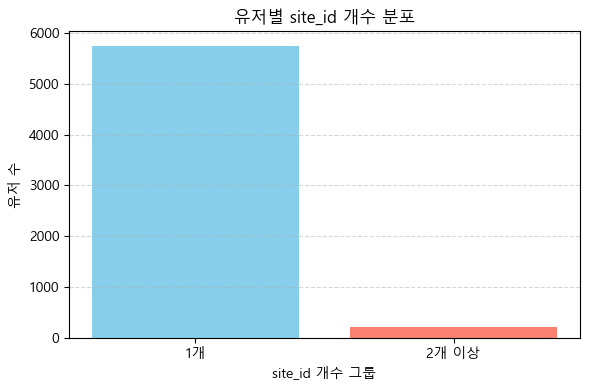

In [519]:
# 유저별 site_id 개수 계산
site_count_per_user = trial_access_log_df.groupby('user_uuid')['site_id'].nunique().reset_index()
site_count_per_user.columns = ['user_uuid', 'unique_site_count']

# 1개인 경우와 1개 초과인 경우로 구분
site_count_per_user['group'] = site_count_per_user['unique_site_count'].apply(lambda x: '1개' if x == 1 else '2개 이상')

# 각 그룹별 유저 수 집계
site_group_counts = site_count_per_user['group'].value_counts().reset_index()
site_group_counts.columns = ['site_id 개수 그룹', '유저 수']

# 결과 출력용 데이터프레임
print(site_group_counts)

plt.figure(figsize=(6, 4))
plt.bar(site_group_counts['site_id 개수 그룹'], site_group_counts['유저 수'], color=['skyblue', 'salmon'])
plt.title('유저별 site_id 개수 분포')
plt.xlabel('site_id 개수 그룹')
plt.ylabel('유저 수')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [520]:
one_site_ids = site_count_per_user[site_count_per_user['unique_site_count'] == 1]['user_uuid']
trial_access_log_df = trial_access_log_df[trial_access_log_df['user_uuid'].isin(one_site_ids)].copy()
trial_access_log_df['user_uuid'].nunique()

5745

입실, 퇴실에 대한 로그 확인


A안. 유저가 방문 시 첫 로그가 checkin == 1 & 마지막 로그가 checkin ==2 인 경우  (유저별로, 모든 방문이 그런 경우)


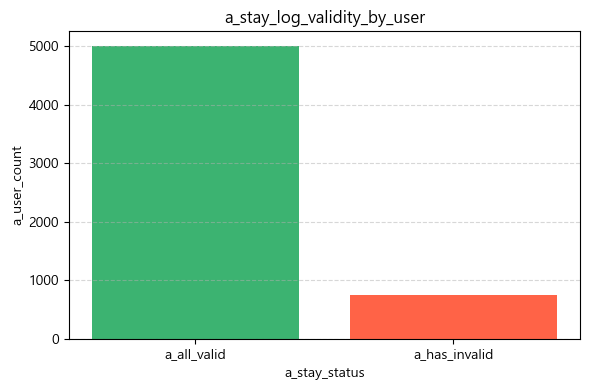

In [521]:
from datetime import timedelta

# 1. 각 유저-날짜별 입/퇴실 시각 정리
a_first_last_checkin = (
    trial_access_log_df
    .sort_values(['user_uuid', 'visit_date', 'cdate'])
    .groupby(['user_uuid', 'visit_date'])['checkin']
    .agg(['first', 'last'])
    .reset_index()
)

# 2. 입실=1, 퇴실=2 → 정상 방문 여부 판단
a_first_last_checkin['a_is_valid_visit'] = (a_first_last_checkin['first'] == 1) & (a_first_last_checkin['last'] == 2)

# 3. 유저별 모든 방문이 유효한지 확인
a_user_valid_status = (
    a_first_last_checkin
    .groupby('user_uuid')['a_is_valid_visit']
    .all()
    .reset_index()
)

# 4. 그룹 라벨 부여
a_user_valid_status['a_group'] = a_user_valid_status['a_is_valid_visit'].map({True: 'a_all_valid', False: 'a_has_invalid'})

# 5. 시각화용 요약 테이블
a_validity_counts = a_user_valid_status['a_group'].value_counts().reset_index()
a_validity_counts.columns = ['a_stay_status', 'a_user_count']

# 6. 막대 그래프 시각화
plt.figure(figsize=(6, 4))
plt.bar(a_validity_counts['a_stay_status'], a_validity_counts['a_user_count'], color=['mediumseagreen', 'tomato'])
plt.title('a_stay_log_validity_by_user')
plt.xlabel('a_stay_status')
plt.ylabel('a_user_count')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 7. 정상 방문 유저만 필터링
a_valid_user_uuids = a_user_valid_status[a_user_valid_status['a_is_valid_visit']]['user_uuid']
a_trial_access_log_df = trial_access_log_df[trial_access_log_df['user_uuid'].isin(a_valid_user_uuids)].copy()

# 8. 입실/퇴실 시각 계산
a_checkin_times = (
    a_trial_access_log_df
    .sort_values(['user_uuid', 'visit_date', 'cdate'])
    .groupby(['user_uuid', 'visit_date', 'checkin'])['cdate']
    .first()
    .unstack()
    .reset_index()
    .rename(columns={1: 'a_checkin_time', 2: 'a_checkout_time'})
)

# 9. 체류 시간 계산 (분 단위)
a_checkin_times['a_stay_duration_minutes'] = (
    (a_checkin_times['a_checkout_time'] - a_checkin_times['a_checkin_time']).dt.total_seconds() / 60
)

# 10. 다시 로그에 병합
a_trial_access_log_df = pd.merge(
    a_trial_access_log_df,
    a_checkin_times[['user_uuid', 'visit_date', 'a_stay_duration_minutes']],
    on=['user_uuid', 'visit_date'],
    how='left'
)


B안. 1-2, 1-2 가 완벽한 경우

  b_log_status  b_user_count
0  b_all_clean          3715
1  b_has_dirty          2030


C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\635052591.py:12: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



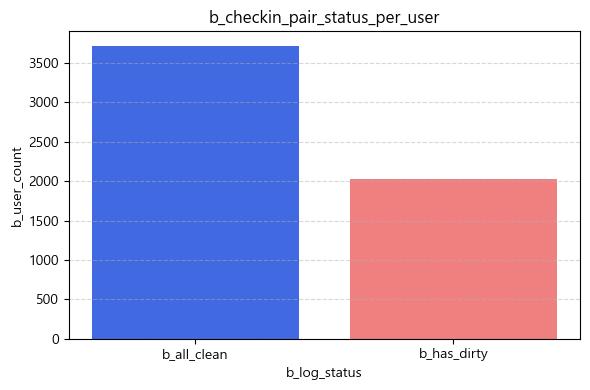

C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\635052591.py:63: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [522]:
# 1. 유저-날짜별 정확한 1-2 순서 확인 함수
def b_is_clean_visit(group):
    checkins = group.sort_values('cdate')['checkin'].tolist()
    if len(checkins) % 2 != 0:
        return False
    return all(checkins[i] == 1 and checkins[i+1] == 2 for i in range(0, len(checkins), 2))

# 2. 유저-날짜별 방문 정상 여부 판별
b_visit_validity = (
    trial_access_log_df
    .groupby(['user_uuid', 'visit_date'])
    .apply(b_is_clean_visit)
    .reset_index()
)
b_visit_validity.columns = ['user_uuid', 'visit_date', 'b_is_clean']

# 3. 유저별 모든 방문이 정상인지 확인
b_user_clean_status = (
    b_visit_validity
    .groupby('user_uuid')['b_is_clean']
    .all()
    .reset_index()
)
b_user_clean_status['b_group'] = b_user_clean_status['b_is_clean'].map({True: 'b_all_clean', False: 'b_has_dirty'})

# 4. 요약 테이블
b_clean_counts = b_user_clean_status['b_group'].value_counts().reset_index()
b_clean_counts.columns = ['b_log_status', 'b_user_count']
print(b_clean_counts)

# 5. 막대그래프
plt.figure(figsize=(6, 4))
plt.bar(b_clean_counts['b_log_status'], b_clean_counts['b_user_count'], color=['royalblue', 'lightcoral'])
plt.title('b_checkin_pair_status_per_user')
plt.xlabel('b_log_status')
plt.ylabel('b_user_count')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 6. 정상 유저만 추출
b_valid_user_uuids = b_user_clean_status[b_user_clean_status['b_is_clean']]['user_uuid']
b_trial_access_log_df = trial_access_log_df[trial_access_log_df['user_uuid'].isin(b_valid_user_uuids)].copy()

# 7. 유저-날짜별로 정렬된 로그에서 1-2 쌍 추출 후 체류시간 계산
def calculate_total_stay_time(group):
    logs = group.sort_values('cdate')
    times = logs['cdate'].tolist()
    checkins = logs['checkin'].tolist()
    
    total_seconds = 0
    for i in range(0, len(checkins), 2):
        if checkins[i] == 1 and checkins[i+1] == 2:
            in_time = times[i]
            out_time = times[i+1]
            total_seconds += (out_time - in_time).total_seconds()
    return total_seconds / 60  # 분 단위로 반환

# 8. 체류시간 계산
b_stay_duration_df = (
    b_trial_access_log_df
    .groupby(['user_uuid', 'visit_date'])
    .apply(calculate_total_stay_time)
    .reset_index(name='b_stay_duration_minutes')
)

# 9. 병합
b_trial_access_log_df = pd.merge(
    b_trial_access_log_df,
    b_stay_duration_df,
    on=['user_uuid', 'visit_date'],
    how='left'
)


### 5.2 데이터 가공

5.2.1 A안

In [523]:
# 1. A안 date grid 생성 (방문자 기준, 중복 제거)
a_date_grid = (
    a_trial_access_log_df[['user_uuid', 'visit_date']]
    .drop_duplicates()
    .rename(columns={'visit_date': 'target_date'})
)

# 2. 요일 주말 여부
a_date_grid['target_date'] = pd.to_datetime(a_date_grid['target_date'])
a_date_grid['is_weekend'] = a_date_grid['target_date'].dt.dayofweek.isin([5, 6]).astype(int)

# 3. visited_today (방문자 기준이므로 전부 1)
a_date_grid['visited_today'] = 1

# 4. 다음날 방문 여부
a_next_day = a_date_grid.copy()
a_next_day['target_date'] = a_next_day['target_date'] - timedelta(days=1)
a_next_day['visit_next_day'] = 1

a_model_df = a_date_grid.merge(
    a_next_day[['user_uuid', 'target_date', 'visit_next_day']],
    on=['user_uuid', 'target_date'],
    how='left'
)
a_model_df['visit_next_day'] = a_model_df['visit_next_day'].fillna(0).astype(int)

# 5. 이전 1,2일 방문 여부
for lag, col in zip([1, 2], ['prev_1day_visited', 'prev_2day_visited']):
    a_lag = a_date_grid.copy()
    a_lag['target_date'] = a_lag['target_date'] + timedelta(days=lag)
    a_lag[col] = 1
    a_model_df = a_model_df.merge(a_lag[['user_uuid', 'target_date', col]], on=['user_uuid', 'target_date'], how='left')
    a_model_df[col] = a_model_df[col].fillna(0).astype(int)

# 6. days_from_register 계산
a_model_df = a_model_df.merge(
    trial_register_df[['user_uuid', 'trial_date']],
    on='user_uuid',
    how='left'
)
a_model_df['trial_date'] = pd.to_datetime(a_model_df['trial_date'])
a_model_df['days_from_register'] = (a_model_df['target_date'] - a_model_df['trial_date']).dt.days

# 7. trial_date + 2일보다 이후는 제거
a_model_df = a_model_df[a_model_df['days_from_register'].between(0, 2)]

# 8. 마지막날 다음날 방문은 0으로 고정
a_model_df.loc[a_model_df['days_from_register'] == 2, 'visit_next_day'] = 0


# 9. 체류시간 병합
a_checkin_summary = (
    a_trial_access_log_df[['user_uuid', 'visit_date', 'a_stay_duration_minutes']]
    .drop_duplicates()
    .rename(columns={'visit_date': 'target_date', 'a_stay_duration_minutes': 'stay_duration_minutes'})
)
a_checkin_summary['target_date'] = pd.to_datetime(a_checkin_summary['target_date'])

a_model_df = a_model_df.merge(a_checkin_summary, on=['user_uuid', 'target_date'], how='left')

# ✅ 최종 A안 모델링 테이블
a_final_model_df = a_model_df[[
    'user_uuid', 'target_date', 'days_from_register', 'is_weekend',
    'prev_1day_visited', 'prev_2day_visited', 'visited_today',
    'visit_next_day', 'stay_duration_minutes'
]]

# A안: 등록일 추가
a_final_model_df = a_final_model_df.merge(
    trial_register_df[['user_uuid', 'trial_date']],
    on='user_uuid',
    how='left'
)

a_final_model_df = a_final_model_df.sort_values(['user_uuid', 'target_date']).reset_index(drop=True)

In [524]:
# 1. B안 date grid 생성 (방문자 기준)
b_date_grid = (
    b_trial_access_log_df[['user_uuid', 'visit_date']]
    .drop_duplicates()
    .rename(columns={'visit_date': 'target_date'})
)

# 2. 요일 주말 여부
b_date_grid['target_date'] = pd.to_datetime(b_date_grid['target_date'])
b_date_grid['is_weekend'] = b_date_grid['target_date'].dt.dayofweek.isin([5, 6]).astype(int)

# 3. visited_today (방문자 기준이므로 전부 1)
b_date_grid['visited_today'] = 1

# 4. 다음날 방문 여부
b_next_day = b_date_grid.copy()
b_next_day['target_date'] = b_next_day['target_date'] - timedelta(days=1)
b_next_day['visit_next_day'] = 1

b_model_df = b_date_grid.merge(
    b_next_day[['user_uuid', 'target_date', 'visit_next_day']],
    on=['user_uuid', 'target_date'],
    how='left'
)
b_model_df['visit_next_day'] = b_model_df['visit_next_day'].fillna(0).astype(int)

# 5. 이전 1,2일 방문 여부
for lag, col in zip([1, 2], ['prev_1day_visited', 'prev_2day_visited']):
    b_lag = b_date_grid.copy()
    b_lag['target_date'] = b_lag['target_date'] + timedelta(days=lag)
    b_lag[col] = 1
    b_model_df = b_model_df.merge(b_lag[['user_uuid', 'target_date', col]], on=['user_uuid', 'target_date'], how='left')
    b_model_df[col] = b_model_df[col].fillna(0).astype(int)

# 6. days_from_register 계산
b_model_df = b_model_df.merge(
    trial_register_df[['user_uuid', 'trial_date']],
    on='user_uuid',
    how='left'
)
b_model_df['trial_date'] = pd.to_datetime(b_model_df['trial_date'])
b_model_df['days_from_register'] = (b_model_df['target_date'] - b_model_df['trial_date']).dt.days

# 7. trial_date + 2일보다 이후는 제거
b_model_df = b_model_df[b_model_df['days_from_register'].between(0, 2)]

# 8. 마지막날 다음날 방문은 0으로 고정
b_model_df.loc[b_model_df['days_from_register'] == 2, 'visit_next_day'] = 0

# 9. 체류시간 병합
b_checkin_summary = (
    b_trial_access_log_df[['user_uuid', 'visit_date', 'b_stay_duration_minutes']]
    .drop_duplicates()
    .rename(columns={'visit_date': 'target_date', 'b_stay_duration_minutes': 'stay_duration_minutes'})
)

b_checkin_summary['target_date'] = pd.to_datetime(b_checkin_summary['target_date'])

b_model_df = b_model_df.merge(b_checkin_summary, on=['user_uuid', 'target_date'], how='left')

# ✅ 최종 B안 모델링 테이블
b_final_model_df = b_model_df[[
    'user_uuid', 'target_date', 'days_from_register', 'is_weekend',
    'prev_1day_visited', 'prev_2day_visited', 'visited_today',
    'visit_next_day', 'stay_duration_minutes'
]]

# B안: 등록일 추가
b_final_model_df = b_final_model_df.merge(
    trial_register_df[['user_uuid', 'trial_date']],
    on='user_uuid',
    how='left'
)

b_final_model_df = b_final_model_df.sort_values(['user_uuid', 'target_date']).reset_index(drop=True)

# 1. 유저별 방문일 수 계산
visit_counts = b_final_model_df.groupby('user_uuid')['visited_today'].sum().reset_index()
visit_counts = visit_counts[visit_counts['visited_today'] == 3]

# 2. 3일 모두 방문한 유저들의 로그 추출
b_3days_visited_df = b_final_model_df[b_final_model_df['user_uuid'].isin(visit_counts['user_uuid'])]

# 3. 날짜 기준 정렬
b_3days_visited_df = b_3days_visited_df.sort_values(by=['user_uuid', 'target_date']).reset_index(drop=True)


# 6. 탐색적 자료 분석

퍼널: 무료 체험 등록 -> 첫 방문 -> 재방문 -> 결제

In [525]:
import plotly.express as px

# 퍼널 단계별 사용자 수 계산
registrations = trial_register_df['user_uuid'].nunique()
access_counts = trial_access_log_df.groupby('user_uuid').size()
first_visits = access_counts.size
revisits = (access_counts > 1).sum()
payments = trial_payment_df[trial_payment_df['is_payment'] == 1]['user_uuid'].nunique()

# 퍼널 차트용 DataFrame 생성
funnel_df = pd.DataFrame({
    'stage': ['무료 체험 등록', '재방문', '결제'],
    'count': [registrations,  revisits, payments]
})

# Plotly로 퍼널 차트 그리기
fig = px.funnel(
    funnel_df,
    x='count',
    y='stage',
    title='퍼널 차트: 무료 체험 등록 → 결제'
)
fig.show()

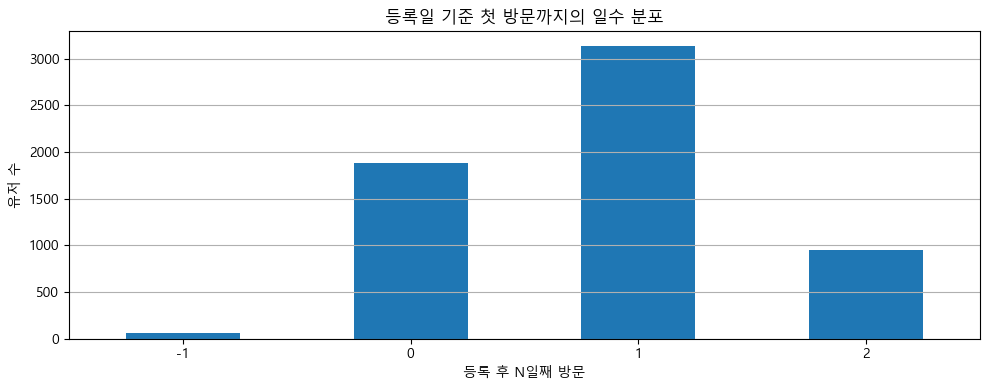

In [526]:
# 등록일 기준 첫 방문까지의 일수 분포
plt.figure(figsize=(10, 4))
visit_day_diff_count.plot(kind="bar")
plt.title("등록일 기준 첫 방문까지의 일수 분포")
plt.xlabel("등록 후 N일째 방문")
plt.ylabel("유저 수")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


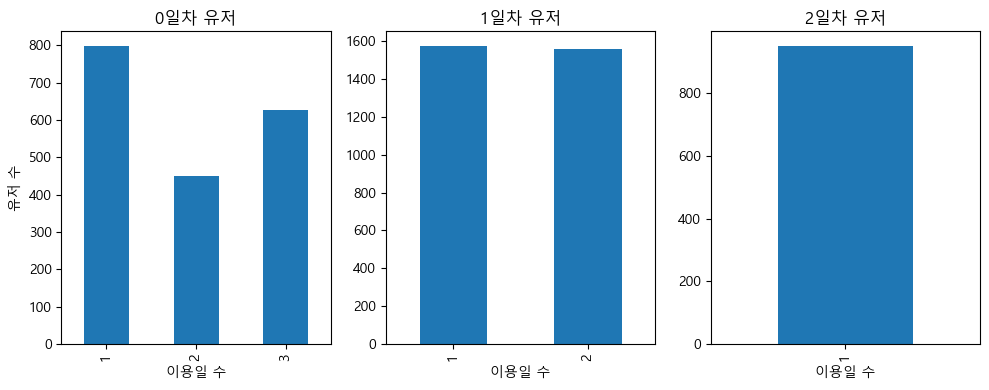

In [527]:
# 시각화
plt.figure(figsize=(10, 4))

# 0일차
plt.subplot(1, 3, 1)
group0.plot(kind="bar")
plt.title("0일차 유저")
plt.xlabel("이용일 수")
plt.ylabel("유저 수")

# 1일차
plt.subplot(1, 3, 2)
group1.plot(kind="bar")
plt.title("1일차 유저")
plt.xlabel("이용일 수")

# 2일차
plt.subplot(1, 3, 3)
group2.plot(kind="bar")
plt.title("2일차 유저")
plt.xlabel("이용일 수")

plt.tight_layout()
plt.show()


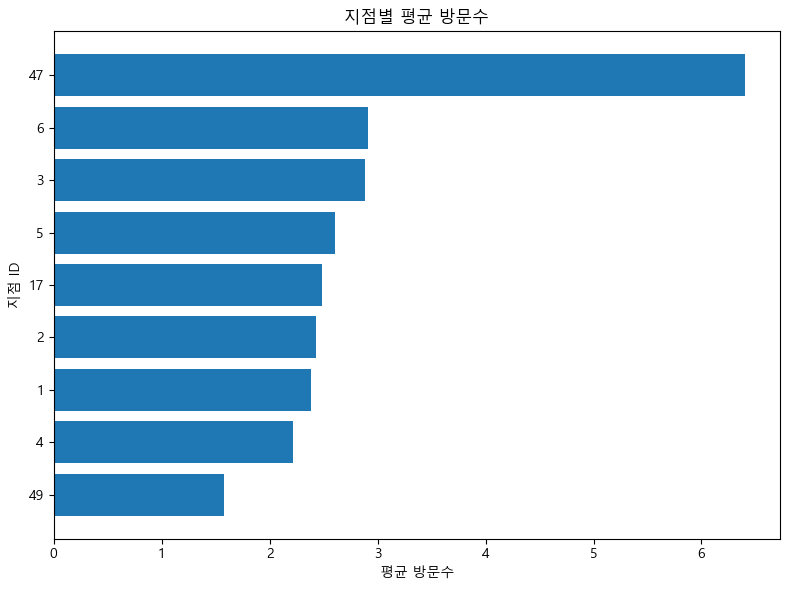

In [528]:
# 지점별 평균 방문수
daily_data = pd.read_csv('C:/Users/Yoo/Desktop/codeit/중급 프로젝트/중급_2/Data/daily_data.csv', encoding='CP949')
df = daily_data.copy()

site_visits = df.groupby('site_id')['daily_site_visits'].mean().sort_values()
site_usage = df.groupby('site_id')['daily_site_usage_hours'].mean().sort_values()
site_density = df.groupby('site_id')['occupancy_density'].mean().sort_values()

plt.figure(figsize=(8,6))
plt.barh(site_visits.index.astype(str), site_visits.values)
plt.title('지점별 평균 방문수')
plt.xlabel('평균 방문수')
plt.ylabel('지점 ID')
plt.tight_layout()
plt.show()


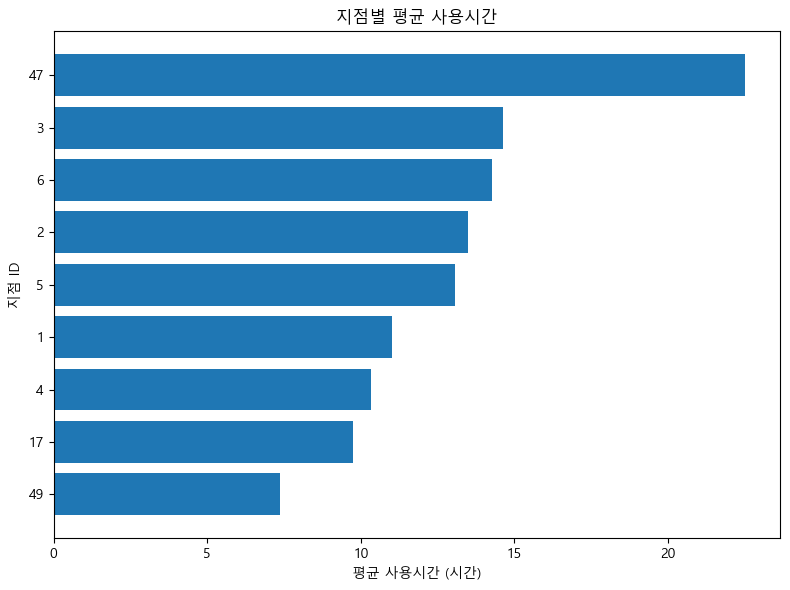

In [529]:
# 지점별 평균 사용시간

plt.figure(figsize=(8,6))
plt.barh(site_usage.index.astype(str), site_usage.values)
plt.title('지점별 평균 사용시간')
plt.xlabel('평균 사용시간 (시간)')
plt.ylabel('지점 ID')
plt.tight_layout()
plt.show()

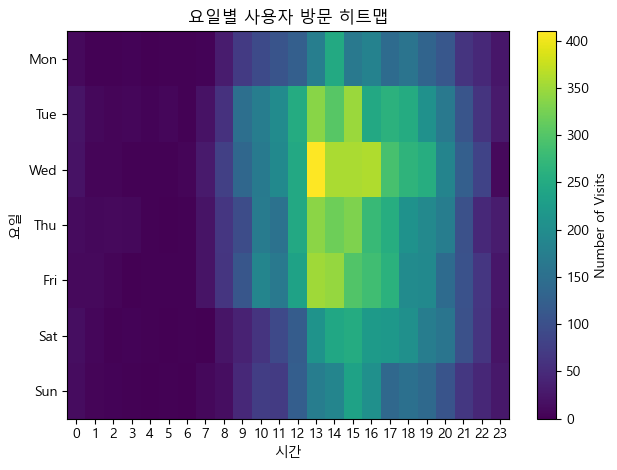

In [530]:
df = pd.read_csv('access_log.csv', encoding='cp949')

df['checkin_time'] = pd.to_datetime(df['checkin_time'], errors='coerce')
df['stay_td'] = pd.to_timedelta(df['stay_time'], errors='coerce')
df['stay_minutes'] = df['stay_td'].dt.total_seconds() / 60
df['is_payment'] = df['is_payment'].astype(int)
df['is_weekend'] = df['is_weekend'].astype(int)
df['checkout_time'] = pd.to_datetime(df['checkout_time'], errors='coerce')
df['checkout_time'] = df['checkout_time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Seoul')
df['checkin_time'] = df['checkin_time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Seoul')

# KST 기반 시간·요일 컬럼 생성
df['hour_kst'] = df['checkin_time'].dt.hour
df['weekday_kst'] = df['checkin_time'].dt.weekday  # 0=Mon, ..., 6=Sun

# 시간대별·요일별 방문 피벗
pivot_kst = df.pivot_table(
    index='weekday_kst',
    columns='hour_kst',
    values='user_uuid',
    aggfunc='count',
    fill_value=0
)
# 히트맵 시각화 (KST)
plt.figure()
plt.imshow(pivot_kst, aspect='auto')
plt.colorbar(label='Number of Visits')
plt.xticks(range(24), range(24))
plt.yticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.xlabel('시간')
plt.ylabel('요일')
plt.title('요일별 사용자 방문 히트맵')
plt.tight_layout()
plt.show()

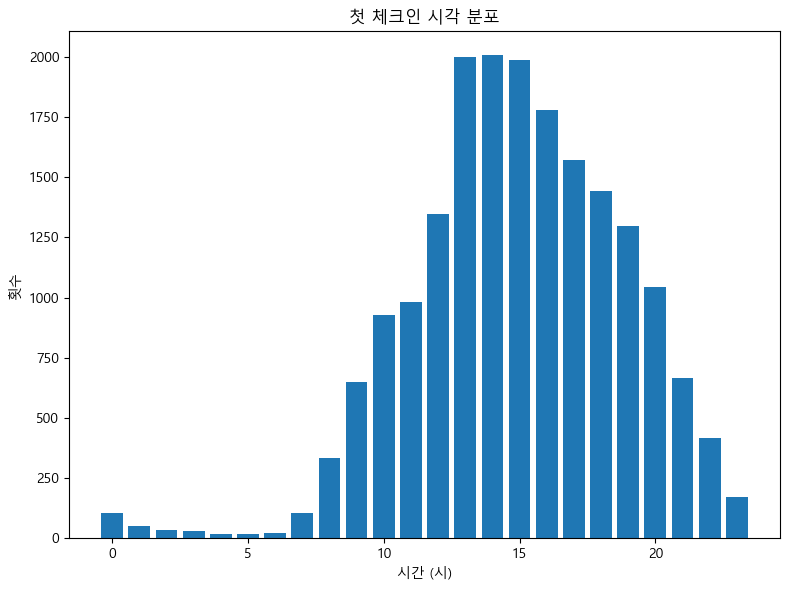

In [531]:
# 첫 체크인 시각 분포
df['체크인_시간'] = df['checkin_time'].dt.hour
hour_counts = df['체크인_시간'].dropna().value_counts().sort_index()

plt.figure(figsize=(8,6))
plt.bar(hour_counts.index, hour_counts.values)
plt.title('첫 체크인 시각 분포')
plt.xlabel('시간 (시)')
plt.ylabel('횟수')
plt.tight_layout()
plt.show()

In [532]:
df['체크인_시간'].value_counts()

체크인_시간
14    2006
13    1998
15    1989
16    1781
17    1571
18    1442
12    1348
19    1296
20    1045
11     981
10     926
21     667
9      648
22     415
8      333
23     171
7      105
0      103
1       49
2       36
3       28
6       21
5       19
4       17
Name: count, dtype: int64

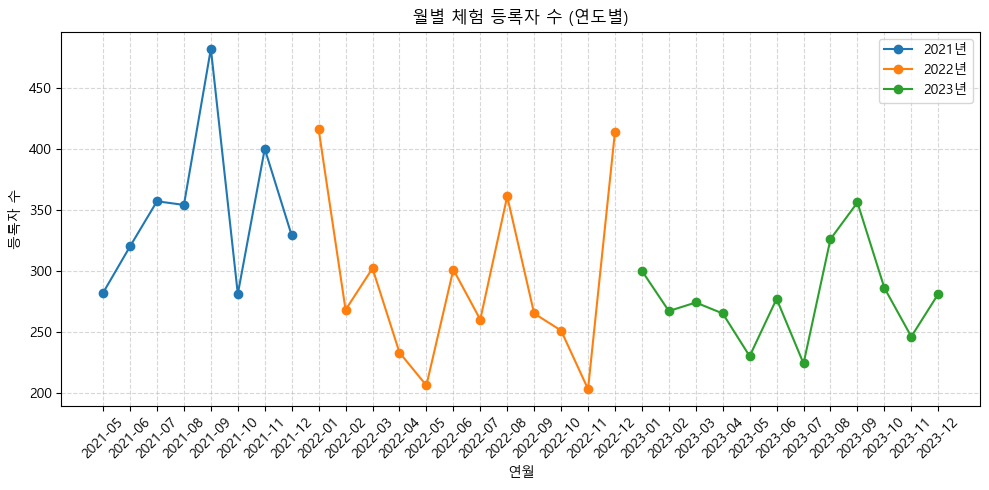

In [533]:
# datetime 변환
trial_register_df['trial_date'] = pd.to_datetime(trial_register_df['trial_date'], format='mixed')

# 연도와 월 추출
trial_register_df['year'] = trial_register_df['trial_date'].dt.year
trial_register_df['month'] = trial_register_df['trial_date'].dt.month

# 년-월 형태 문자열 추가 (시계열 정렬용)
trial_register_df['year_month'] = trial_register_df['trial_date'].dt.to_period('M').astype(str)

# 월별 신청자 수 집계
monthly_counts = (
    trial_register_df
    .groupby(['year', 'month', 'year_month'])
    .size()
    .reset_index(name='user_count')
    .sort_values('year_month')
)

# 그래프 준비
plt.figure(figsize=(10, 5))

# 연도별로 라인 나눠서 그리기
for year in sorted(monthly_counts['year'].unique()):
    data = monthly_counts[monthly_counts['year'] == year]
    plt.plot(data['year_month'], data['user_count'], marker='o', label=f'{year}년')

# 시각화 옵션
plt.title('월별 체험 등록자 수 (연도별)')
plt.xlabel('연월')
plt.ylabel('등록자 수')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

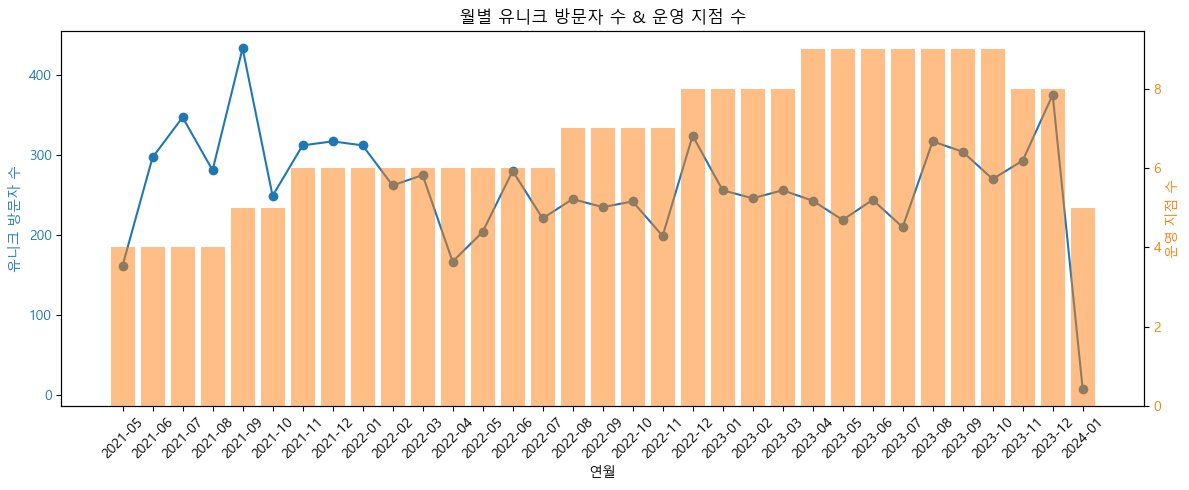

In [534]:
# 0. 날짜 컬럼 처리
trial_access_log_df['cdate'] = pd.to_datetime(trial_access_log_df['cdate'], format='mixed')
trial_access_log_df['visit_date'] = trial_access_log_df['cdate'].dt.date
trial_access_log_df['year_month'] = trial_access_log_df['cdate'].dt.to_period('M').astype(str)

# 1. 유니크 방문자 수 계산 (user_uuid + visit_date 기준)
visit_counts = (
    trial_access_log_df
    .drop_duplicates(subset=['user_uuid', 'visit_date'])
    .groupby('year_month')
    .size()
    .reset_index(name='unique_visit_count')
)

# 2. 해당 월의 운영 지점 수 계산
site_counts = (
    trial_access_log_df
    .drop_duplicates(subset=['site_id', 'year_month'])
    .groupby('year_month')['site_id']
    .nunique()
    .reset_index(name='open_site_count')
)

# 3. 두 테이블 병합
visit_summary = pd.merge(visit_counts, site_counts, on='year_month')

# 4. 시각화 (이중축)
fig, ax1 = plt.subplots(figsize=(12, 5))

# 왼쪽 y축: 방문자 수 (라인)
ax1.plot(visit_summary['year_month'], visit_summary['unique_visit_count'], color='tab:blue', marker='o', label='유니크 방문자 수')
ax1.set_ylabel('유니크 방문자 수', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlabel('연월')
ax1.tick_params(axis='x', rotation=45)

# 오른쪽 y축: 지점 수 (막대)
ax2 = ax1.twinx()
ax2.bar(visit_summary['year_month'], visit_summary['open_site_count'], color='tab:orange', alpha=0.5, label='운영 지점 수')
ax2.set_ylabel('운영 지점 수', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# 타이틀 및 정리
plt.title('월별 유니크 방문자 수 & 운영 지점 수')
fig.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

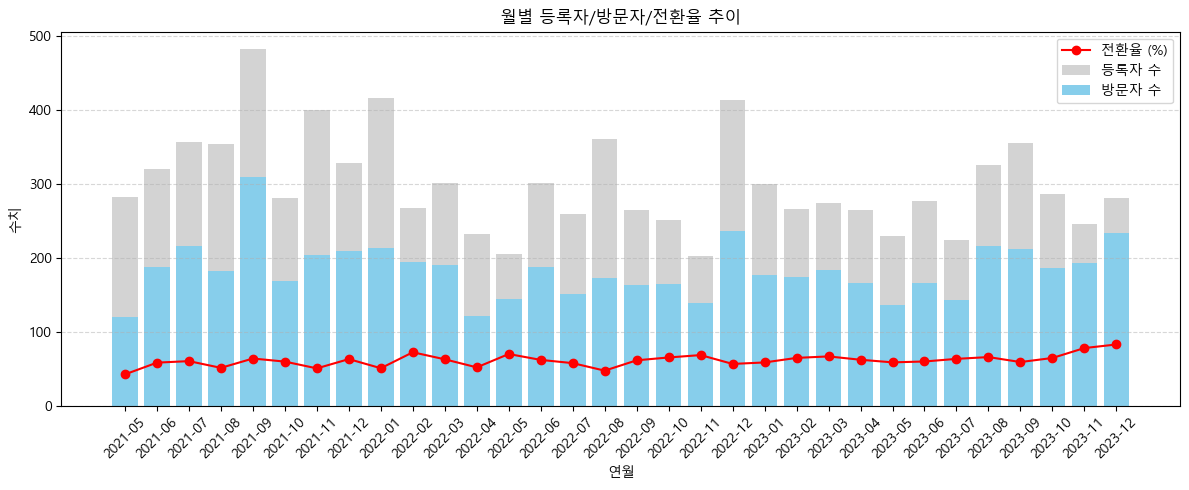

In [535]:
# 1. trial_register_df 전처리
trial_register_df['trial_date'] = pd.to_datetime(trial_register_df['trial_date'], format='mixed')
trial_register_df['year_month'] = trial_register_df['trial_date'].dt.to_period('M').astype(str)

register_counts = (
    trial_register_df
    .groupby('year_month')['user_uuid']
    .nunique()
    .reset_index(name='register_count')
)

# 2. trial_access_log_df_1 전처리
trial_access_log_df['cdate'] = pd.to_datetime(trial_access_log_df['cdate'], format='mixed')
trial_access_log_df['visit_date'] = trial_access_log_df['cdate'].dt.date
trial_access_log_df['year_month'] = trial_access_log_df['cdate'].dt.to_period('M').astype(str)

visit_counts = (
    trial_access_log_df
    .drop_duplicates(subset=['user_uuid', 'visit_date'])
    .groupby('year_month')['user_uuid']
    .nunique()
    .reset_index(name='visit_count')
)

# 3. 병합 및 전환율 계산
conversion_df = pd.merge(register_counts, visit_counts, on='year_month', how='left')
conversion_df['conversion_rate'] = (conversion_df['visit_count'] / conversion_df['register_count']) * 100

# 4. 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 막대: 등록 수 & 방문 수
plt.bar(conversion_df['year_month'], conversion_df['register_count'], color='lightgray', label='등록자 수')
plt.bar(conversion_df['year_month'], conversion_df['visit_count'], color='skyblue', label='방문자 수')

# 선: 전환율 (%)
plt.plot(conversion_df['year_month'], conversion_df['conversion_rate'], color='red', marker='o', label='전환율 (%)')

# 설정
plt.title('월별 등록자/방문자/전환율 추이')
plt.xlabel('연월')
plt.ylabel('수치')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [536]:
conversion_df

,year_month,register_count,visit_count,conversion_rate
0,2021-05,282,121,42.907801
1,2021-06,320,188,58.750000
2,2021-07,357,217,60.784314
3,2021-08,354,183,51.694915
4,2021-09,482,310,64.315353
5,2021-10,281,169,60.142349
6,2021-11,400,204,51.000000
7,2021-12,329,209,63.525836
8,2022-01,416,213,51.201923
9,2022-02,268,195,72.761194


# 7. 모델

### 7.1 사용 모델

- 로지스틱 회귀 분석 (Baseline): 가장 단순하고 해석이 쉬운 선형 모델로, 입력 피처와 재방문 확률 간의 관계를 로지스틱 함수로 설명함.
- 서포트 벡터 머신:  N차원 공간에서 각 클래스 간의 거리를 최대화하는 최적의 선 또는 초평면을 찾아 데이터를 분류하는 지도학습 알고리즘. 이진 분류에 강함
- 랜덤 포레스트: 다수의 결정 트리를 랜덤하게 학습시켜 예측을 앙상블하는 방법으로, 비선형 관계와 변수 간 상호작용을 잘 포작할 수 있음
- 부스팅 모델 (LightGBM, XGBoost 등): 트리를 순차적으로 학습시키며 이전 모델이 틀린 사례에 가중치를 두어 보완해 나가는 방식.

### 7.2 데이터 불균형 처리

예측 대상인 ‘익일 재방문’이 전체 방문 대비 상대적으로 적은 경우, 모델이 소수 클래스(재방문)에 대해 민감도를 잃을 수 있기 때문에 데이터 불균형이 발견된 경우 SMOTE 기법을 통해 불균형을 조정

### 7.3 교차 검증 및 하이퍼 파라미터 튜닝

TimeSeriesSplit 를 활용한 시계열 교차검증을 적용하여, 과거 데이터를 기반으로 미래를 예측하는 실제 운영 환경 시뮬레이션을 수행. </br>
각 분할마다 모델을 학습·평가하여 일반화 성능을 안정적으로 측정하며, 시차에 따른 분포 변동 영향을 최소화 하는 역할. </br>
하이퍼 파라미터 튜닝 은 Randomized Search 방식을 채택.



### 7.4 평가 지표

- ROC-AUC: 전체 분류 임계값에 걸친 민감도와 특이도의 균형을 평가.

- Precision & Recall: 재방문 예측 중 실제 재방문 비율과, 실제 재방문을 얼마나 잘 찾아냈는지를 각각 측정.

- F1-score: Precision과 Recall의 조화 평균으로, 클래스 불균형 상황에서도 균형 잡힌 성능 판단이 가능.

# 8. 모델링 및 성능 평가

In [537]:
import shap
import optuna
from sklearn.model_selection import cross_validate, TimeSeriesSplit, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC


### 8.1 Baseline 모델링

In [538]:
a_final_model_df['visit_next_day'].value_counts(), b_final_model_df['visit_next_day'].value_counts()

(visit_next_day
 0    5119
 1    1994
 Name: count, dtype: int64,
 visit_next_day
 0    3791
 1    1262
 Name: count, dtype: int64)

8.1.1 A안 로지스틱

In [539]:
df_a = a_final_model_df.copy()

df_a.sort_values(by='target_date', inplace=True)

In [540]:
features = ['days_from_register', 'is_weekend', 'prev_1day_visited', 'prev_2day_visited', 'visited_today', 'stay_duration_minutes']

X = df_a[features].copy()
y = df_a['visit_next_day']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

from imblearn.over_sampling import SMOTE

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", X_train.shape, y_train.value_counts().to_dict())
print("After  SMOTE:", X_train_res.shape, y_train_res.value_counts().to_dict())


Before SMOTE: (5690, 6) {0: 4114, 1: 1576}
After  SMOTE: (8228, 6) {0: 4114, 1: 4114}


In [541]:
# 1) 모델 초기화
logreg = LogisticRegression(max_iter=1000)

# 2) 모델 학습
logreg.fit(X_train, y_train)

# 3) 예측
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

# 4) 평가
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.73      0.78      0.76      1005
           1       0.37      0.30      0.33       418

    accuracy                           0.64      1423
   macro avg       0.55      0.54      0.54      1423
weighted avg       0.62      0.64      0.63      1423

ROC AUC Score: 0.7028398676474088


8.1.2 B안 로지스틱

In [542]:
df_b = b_final_model_df.copy()
df_b.sort_values(by='target_date', inplace=True)

features = ['days_from_register', 'is_weekend', 'prev_1day_visited', 'prev_2day_visited', 'visited_today', 'stay_duration_minutes']

X = df_b[features].copy()
y = df_b['visit_next_day']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

from imblearn.over_sampling import SMOTE

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", X_train.shape, y_train.value_counts().to_dict())
print("After  SMOTE:", X_train_res.shape, y_train_res.value_counts().to_dict())

Before SMOTE: (4042, 6) {0: 3044, 1: 998}
After  SMOTE: (6088, 6) {0: 3044, 1: 3044}


In [543]:
# 1) 모델 초기화
logreg = LogisticRegression(max_iter=1000)

# 2) 모델 학습
logreg.fit(X_train, y_train)

# 3) 예측
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

# 4) 평가
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83       747
           1       0.44      0.20      0.27       264

    accuracy                           0.72      1011
   macro avg       0.60      0.55      0.55      1011
weighted avg       0.68      0.72      0.68      1011

ROC AUC Score: 0.7132519978905522


B 데이터가 더 성능이 좋았기때문에 B 데이터 관점에서 피처 엔지니어링을 수행하기로 함

### 8.2 피처 엔지니어링

In [544]:
model_df = b_final_model_df.copy()
model_df
model_df['visit_next_day'].value_counts()
model_df['user_uuid'].nunique()

3715

In [545]:
model_df

,user_uuid,target_date,days_from_register,is_weekend,prev_1day_visited,prev_2day_visited,visited_today,visit_next_day,stay_duration_minutes,trial_date
0,000590dc-046f-462b-8225-4c81a97b7166,2023-09-05,1,0,0,0,1,0,356.964422,2023-09-04
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,2021-09-30,1,0,0,0,1,1,170.381538,2021-09-29
2,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,2021-10-01,2,0,1,0,1,0,156.378054,2021-09-29
3,002606d9-38ca-48f3-910c-cbfada9a9109,2023-01-07,1,1,0,0,1,1,211.496227,2023-01-06
4,002606d9-38ca-48f3-910c-cbfada9a9109,2023-01-08,2,1,1,0,1,0,205.577813,2023-01-06
...,...,...,...,...,...,...,...,...,...,...
5048,ffcb7950-d150-40ae-a6bf-f85f5c2b9702,2022-04-27,2,0,1,0,1,0,240.998780,2022-04-25
5049,ffce32ca-2efc-4485-b685-4b65811c2dcf,2023-11-01,0,0,0,0,1,1,137.425387,2023-11-01
5050,ffce32ca-2efc-4485-b685-4b65811c2dcf,2023-11-02,1,0,1,0,1,0,3.414444,2023-11-01
5051,ffd287bc-2797-4788-82fa-6268c82e7fa9,2023-04-07,1,0,0,0,1,1,161.205068,2023-04-06


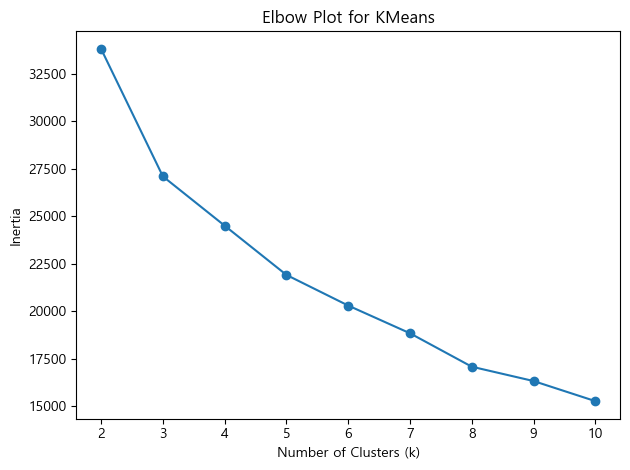

In [546]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


df = daily_data.copy()

# 2. 사용자별 피처 집계
user_feats = df.groupby('user_uuid').agg({
    'daily_site_visits': 'mean',
    'daily_site_usage_hours': 'mean',
    'daily_unique_visitors': 'mean',
    'avg_hours_per_visitor': 'mean',
    'occupancy_density': 'mean',
    'site_daily_occupancy_rate': 'mean',
    'share_of_day_usage': 'mean',
    'share_of_site_usage': 'mean',
    'is_payment': 'mean',
    'use_date': 'count'
}).rename(columns={'use_date': 'visit_count'})

# 3. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_feats)

# 4. 엘보우 기법으로 최적 k 탐색
inertia = []
ks = range(2, 11)
for k in ks:
    inertia.append(KMeans(n_clusters=k, random_state=42).fit(X_scaled).inertia_)

plt.figure()
plt.plot(ks, inertia, marker='o')
plt.title('Elbow Plot for KMeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

# 5. 최종 k=4로 군집화
k_final = 4
kmeans = KMeans(n_clusters=k_final, random_state=42).fit(X_scaled)
user_feats['cluster'] = kmeans.labels_

# 6. 클러스터별 요약 통계
cluster_summary = user_feats.groupby('cluster').agg({
    'visit_count': 'count',
    'daily_site_visits': 'mean',
    'daily_site_usage_hours': 'mean',
    'occupancy_density': 'mean',
    'is_payment': 'mean'
}).rename(columns={'visit_count': 'user_count',
                   'is_payment': 'payment_rate'})

사용자 이용 패턴에 군집분석을 수행해 4개의 군집으로 분류했다. 이를 cluster 라는 컬럼에 저장하여 파생변수로 추가하였다.

In [547]:
user_feats = user_feats.reset_index()

In [548]:
cluster_info = user_feats[['user_uuid', 'cluster']]

In [549]:
cluster_summary

,user_count,daily_site_visits,daily_site_usage_hours,occupancy_density,payment_rate
cluster,,,,,
0,1403,1.588580,8.280113,0.021100,0.099786
1,1216,2.108690,8.582214,0.011504,0.989309
2,44,25.636364,80.739091,0.018364,0.318182
3,1429,4.012538,19.928735,0.012471,0.184045


In [ ]:
import pandas as pd

def preprocess_weather(frames, date_col='일시'):
    """
    날씨 데이터 리스트를 전처리하여 하나의 DataFrame으로 반환
    - 결측치는 0으로 채움
    - date_col을 'target_date'로 변환 후 datetime 처리
    - '지점' 컬럼 제거
    """
    processed = []
    for df in frames:
        tmp = df.copy()
        tmp.fillna(0, inplace=True)
        tmp = tmp.rename(columns={date_col: 'target_date'})
        tmp['target_date'] = pd.to_datetime(tmp['target_date'])
        tmp = tmp.drop(columns=['지점'], errors='ignore')
        processed.append(tmp)
    return pd.concat(processed, ignore_index=True)

# --- 데이터 로딩 -----------------------------------------------------------
# 모델 결과 데이터
base_df = b_final_model_df.copy()

# 날씨 데이터
weather_keys = [
    'SURFACE_ASOS_108_DAY_2021_2021_2022.csv',
    'SURFACE_ASOS_108_DAY_2022_2022_2023.csv',
    'SURFACE_ASOS_108_DAY_2023_2023_2024.csv',
    'SURFACE_ASOS_108_DAY_2024_2024_2025.csv'
]
weather_dfs = [dataframes[k] for k in weather_keys]
daily = daily_data[['user_uuid', 'occupancy_density', 'avg_hours_per_visitor']]
combined_weather = preprocess_weather(weather_dfs)

# 일별 체크인 카운트 데이터
checkin_count = dataframes['daily_checkin_counts.csv']
# user_uuid 기준 merge 준비: 중복 제거 또는 집계 확인
checkin_count = checkin_count.drop_duplicates(subset=['user_uuid'])

# 사이트 면적 정보
area_df = site_area_df.copy()

# trial access log에서 site 정보
site_df = trial_access_log_df[['user_uuid', 'site_id']].drop_duplicates()

# --- 병합 파이프라인 -------------------------------------------------------
merged_df = (
    base_df
    # 날짜 컬럼 target_date가 문자열일 경우 변환
    .assign(target_date=lambda df: pd.to_datetime(df['target_date']))
    # 날씨 데이터 병합
    .merge(combined_weather, on='target_date', how='left')
    # site_id 정보 병합
    .merge(site_df, on='user_uuid', how='left')
    # 사이트 면적 정보 병합
    .merge(area_df, on='site_id', how='left')
    # 일별 체크인 카운트 정보 병합
    .merge(checkin_count, on='user_uuid', how='left')
    .merge(trial_payment_df, on='user_uuid', how='left')
    .merge(daily, on='user_uuid', how='left')
    .merge(cluster_info, on='user_uuid',how='left')
)

# 결과 확인

merged_df

,user_uuid,target_date,days_from_register,is_weekend,prev_1day_visited,prev_2day_visited,visited_today,visit_next_day,stay_duration_minutes,trial_date,...,일강수량(mm),평균 풍속(m/s),site_id,area_pyeong,visit_date,daily_checkin_count,is_payment,occupancy_density,avg_hours_per_visitor,cluster
0,000590dc-046f-462b-8225-4c81a97b7166,2023-09-05,1,0,0,0,1,0,356.964422,2023-09-04,...,0.0,1.8,6,150,2023-09-05,3,0,0.012,4.98,3
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,2021-09-30,1,0,0,0,1,1,170.381538,2021-09-29,...,0.0,1.5,3,150,2021-09-30,7,1,0.005,4.30,1
2,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,2021-09-30,1,0,0,0,1,1,170.381538,2021-09-29,...,0.0,1.5,3,150,2021-09-30,7,1,0.008,4.57,1
3,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,2021-10-01,2,0,1,0,1,0,156.378054,2021-09-29,...,13.3,2.4,3,150,2021-09-30,7,1,0.005,4.30,1
4,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,2021-10-01,2,0,1,0,1,0,156.378054,2021-09-29,...,13.3,2.4,3,150,2021-09-30,7,1,0.008,4.57,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8023,ffce32ca-2efc-4485-b685-4b65811c2dcf,2023-11-02,1,0,1,0,1,0,3.414444,2023-11-01,...,0.0,2.9,4,100,2023-11-01,1,0,0.035,4.68,0
8024,ffd287bc-2797-4788-82fa-6268c82e7fa9,2023-04-07,1,0,0,0,1,1,161.205068,2023-04-06,...,0.0,2.9,6,150,2023-04-07,4,0,0.015,5.51,0
8025,ffd287bc-2797-4788-82fa-6268c82e7fa9,2023-04-07,1,0,0,0,1,1,161.205068,2023-04-06,...,0.0,2.9,6,150,2023-04-07,4,0,0.006,2.94,0
8026,ffd287bc-2797-4788-82fa-6268c82e7fa9,2023-04-08,2,1,1,0,1,0,395.063402,2023-04-06,...,0.0,3.2,6,150,2023-04-07,4,0,0.015,5.51,0


기상청에서 서울의 일별 평균 온도, 강우, 풍속 데이터를 사용해 날씨가 재방문에 얼마나 영향을 끼치는지 확인하고자 컬럼을 추가하였다.

In [ ]:
df = merged_df.copy()

df['area_squared_meter'] = df['area_pyeong'] * 3.306 # 제곱미터로 변환
df['is_pandemic'] = (df['target_date'] <= pd.to_datetime('2022-04-18')).astype(int) # 거리두기 여부
df['days_of_week'] = df['target_date'].dt.day_of_week # 요일 정보 추가
df['month'] = df['target_date'].dt.month # 월 정보 추가
df['year'] = df['target_date'].dt.year # 년 정보 추가
df['is_peak_day_visitor'] = (
    (df['target_date'].dt.weekday == 2) |
    (df['target_date'].dt.weekday == 4) # 히트맵 정보를 통해 얻은 피크 시간대 
).astype(int)

import holidays
kr_holidays = holidays.KR()

df['is_holiday'] = df['target_date'].dt.date.isin(kr_holidays) 
df['is_weekend'] = df['target_date'].dt.weekday >= 5
df['is_workday'] = (~df['is_holiday'] & ~df['is_weekend']).astype(int) # 출근하는 날과 그렇지 않은 날을 구분하는 이진 변수

이 외의 파생변수에 대한 설명
- occupancy_density: 일일 사용자 / 지점별 면적
- avg_hours_per_visitor: 해당 지점의 일일 평균 사용량
- cluster: 사용자 행동 패턴에 의한 군집

In [552]:
df.drop_duplicates(inplace=True)

In [553]:
df['user_uuid'].nunique()

3715

In [554]:
df['visit_next_day'].value_counts()

visit_next_day
0    5241
1    2787
Name: count, dtype: int64

In [555]:
df.rename(columns={
    '평균기온(°C)': 'avg_temp',
    '일강수량(mm)': 'avg_precipitation',
    '평균 풍속(m/s)': 'avg_windspeed'
}, inplace=True)

In [557]:
cols = ['is_weekend', 'trial_date','area_pyeong', 'is_weekend', 'is_holiday', 'is_weekend', 'visit_date']
df.drop(columns=cols, inplace=True)

In [ ]:
df.sort_values(by='target_date', inplace=True)
df.info() # 추가된 데이터 확인

<class 'pandas.core.frame.DataFrame'>
Index: 8028 entries, 7093 to 529
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_uuid              8028 non-null   object        
 1   target_date            8028 non-null   datetime64[ns]
 2   days_from_register     8028 non-null   int64         
 3   prev_1day_visited      8028 non-null   int64         
 4   prev_2day_visited      8028 non-null   int64         
 5   visited_today          8028 non-null   int64         
 6   visit_next_day         8028 non-null   int64         
 7   stay_duration_minutes  8028 non-null   float64       
 8   avg_temp               8028 non-null   float64       
 9   avg_precipitation      8028 non-null   float64       
 10  avg_windspeed          8028 non-null   float64       
 11  site_id                8028 non-null   int64         
 12  daily_checkin_count    8028 non-null   int64         
 13  is_pay

### 8.3 새로운 피처를 포함한 모델링

In [559]:
from imblearn.pipeline import Pipeline as ImbPipeline

features = ['days_from_register', 'prev_1day_visited', 'prev_2day_visited', 'visited_today', 'stay_duration_minutes', 'avg_temp',
            'avg_precipitation', 'avg_windspeed', 'site_id', 'daily_checkin_count', 'is_payment', 'occupancy_density', 'avg_hours_per_visitor',
            'cluster', 'area_squared_meter', 'is_pandemic', 'days_of_week', 'month', 'year', 'is_peak_day_visitor', 'is_workday']

X = df[features].copy()
y = df['visit_next_day']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# 시계열 CV 정의
tscv = TimeSeriesSplit(n_splits=10) # 10-folds

num_features = [
    'days_from_register',
    'prev_1day_visited',
    'prev_2day_visited',
    'visited_today',
    'stay_duration_minutes',
    'avg_temp',
    'avg_precipitation',
    'avg_windspeed',
    'daily_checkin_count',
    'area_squared_meter',
    'occupancy_density',       
    'avg_hours_per_visitor'    
]

cat_features = [
    'site_id',                  # 지점 아이디
    'cluster',                  # 클러스터 라벨
    'year',                     # 연도
    'month',                    # 월
    'days_of_week',             # 요일 (0=Mon,…,6=Sun)
    'is_workday',               # 근무일 여부
    'is_pandemic',              # 팬데믹 전후 플래그
    'is_peak_day_visitor',      # 피크 요일 플래그
    'is_payment'                # 결제 유무 플래그
]

# 전처리기 정의
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
])

# 학습 데이터로 fit & transform
X_train_proc = preprocessor.fit_transform(X_train)

# fit 후에야 get_feature_names_out를 쓸 수 있습니다
feature_names = preprocessor.get_feature_names_out()


In [ ]:
def evaluate_without_shap(pipe, X_train, y_train, X_test, y_test):
    #  테스트 평가
    y_proba = pipe.predict_proba(X_test)[:,1]
    y_pred  = pipe.predict(X_test)
    print("Test ROC-AUC :", roc_auc_score(y_test, y_proba))
    print(classification_report(y_test, y_pred, digits=4))

    # 피처 중요도
    model      = pipe.named_steps['clf']
    feat_names = pipe.named_steps['prep'].get_feature_names_out()

    if hasattr(model, "feature_importances_"):
        imp = model.feature_importances_
        idx = np.argsort(imp)[::-1]
        print("Top 20 features (feature_importances_):")
        for i in idx[:20]:
            print(f"  {feat_names[i]:<30} {imp[i]:.4f}")

    elif hasattr(model, "coef_"):
        coefs = np.abs(model.coef_[0])
        idx   = np.argsort(coefs)[::-1]
        print("Top 20 features (|coef_|):")
        for i in idx[:20]:
            print(f"  {feat_names[i]:<30} {coefs[i]:.4f}")

    else:
        print("  (feature_importances_ 또는 coef_ 속성이 없음)")

def optimize_and_evaluate(name, estimator, param_space=None, n_trials=30):
    pipe = ImbPipeline([
        ('prep',   preprocessor),
        ('smote',  SMOTE(random_state=42)),
        ('clf',    estimator)
    ])

    # Baseline CV
    base_score = cross_val_score(pipe, X_train, y_train,
                                 cv=tscv, scoring='roc_auc', n_jobs=-1).mean()
    print(f"[{name}] Baseline CV ROC-AUC : {base_score:.4f}")

    # Optuna 튜닝
    if param_space:
        def objective(trial):
            params = {k: fn(trial) for k, fn in param_space.items()}
            pipe.set_params(**{f"clf__{k}": v for k, v in params.items()})
            return cross_val_score(pipe, X_train, y_train,
                                  cv=tscv, scoring='roc_auc', n_jobs=-1).mean()

        study = optuna.create_study(direction='maximize',
                                    sampler=optuna.samplers.TPESampler(seed=42))
        study.optimize(objective, n_trials=n_trials)
        print(f"[{name}] Best CV ROC-AUC : {study.best_value:.4f}")
        print(f"[{name}] Best params       : {study.best_params}")
        pipe.set_params(**{f"clf__{k}": v for k, v in study.best_params.items()})

    # 모델 학습 및 평가
    pipe.fit(X_train, y_train)
    evaluate_without_shap(pipe, X_train, y_train, X_test, y_test)
    print("-" * 60)

In [565]:
# 모델 & 파라미터 
models = {
    'LogisticRegression': {
        'est': LogisticRegression(random_state=42, max_iter=1000),
        'space': {
            'C'            : lambda t: t.suggest_loguniform('C', 1e-4, 1e2),
            'penalty'      : lambda t: t.suggest_categorical('penalty', ['l2', None]),
            'solver'       : lambda t: t.suggest_categorical('solver', ['lbfgs','saga']),
            'max_iter'     : lambda t: t.suggest_int('max_iter', 200, 2000),
            'class_weight' : lambda t: t.suggest_categorical('class_weight', [None, 'balanced'])
        },
        'trials': 30
    },
    'RandomForest': {
        'est': RandomForestClassifier(random_state=42, n_jobs=-1),
        'space': {
            'n_estimators'      : lambda t: t.suggest_int('n_estimators', 100, 1000),
            'max_depth'         : lambda t: t.suggest_int('max_depth', 3, 20),
            'min_samples_split' : lambda t: t.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf'  : lambda t: t.suggest_int('min_samples_leaf', 1, 20),
            'max_features'      : lambda t: t.suggest_categorical('max_features', ['sqrt','log2', None]),
            'bootstrap'         : lambda t: t.suggest_categorical('bootstrap', [True]),
            'max_samples'       : lambda t: t.suggest_uniform('max_samples', 0.5, 1.0),
            'class_weight'      : lambda t: t.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample'])
        },
        'trials': 30
    },
    'LightGBM': {
        'est': LGBMClassifier(random_state=42, n_jobs=-1),
        'space': {
            'n_estimators'      : lambda t: t.suggest_int('n_estimators', 50, 1000),
            'learning_rate'     : lambda t: t.suggest_loguniform('learning_rate', 0.01, 0.3),
            'num_leaves'        : lambda t: t.suggest_int('num_leaves', 20, 200),
            'max_depth'         : lambda t: t.suggest_int('max_depth', 3, 30),
            'subsample'         : lambda t: t.suggest_uniform('subsample', 0.5, 1.0),
            'colsample_bytree'  : lambda t: t.suggest_uniform('colsample_bytree', 0.5, 1.0),
            'reg_alpha'         : lambda t: t.suggest_loguniform('reg_alpha', 1e-8, 10.0),
            'reg_lambda'        : lambda t: t.suggest_loguniform('reg_lambda', 1e-8, 10.0),
            'min_split_gain'    : lambda t: t.suggest_loguniform('min_split_gain', 1e-8, 1.0),
            'min_child_samples' : lambda t: t.suggest_int('min_child_samples', 5, 100)
        },
        'trials': 30
    },
    'SVM': {
        'est': SVC(random_state=42, probability=True),
        'space': {
            'C'      : lambda t: t.suggest_loguniform('C', 1e-3, 1e3),
            'kernel' : lambda t: t.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
            'gamma'  : lambda t: t.suggest_categorical('gamma', ['scale', 'auto']),
            'degree' : lambda t: t.suggest_int('degree', 2, 5),       # poly 커널에만 의미
            'coef0'  : lambda t: t.suggest_uniform('coef0', 0.0, 1.0)  # poly/RBF 커널에만 의미
        },
        'trials': 15
    }
}

# 개별 모델 튜닝 & 평가
for name, cfg in models.items():
    optimize_and_evaluate(
        name,
        cfg['est'],
        cfg.get('space', None),
        cfg.get('trials', 30)
    )

[I 2025-06-16 15:26:03,015] A new study created in memory with name: no-name-b7f8f5be-ff41-41f1-8d21-5c37d2f3024f


[LogisticRegression] Baseline CV ROC-AUC : 0.8009


C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\3316228033.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-06-16 15:26:04,599] Trial 0 finished with value: 0.8016662377476361 and parameters: {'C': 0.017670169402947963, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 480, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8016662377476361.
[I 2025-06-16 15:26:05,797] Trial 1 finished with value: 0.8028547498818022 and parameters: {'C': 0.4042872735027334, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 582, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8028547498818022.
[I 2025-06-16 15:26:05,906] Trial 2 finished with value: 0.7964486964088252 and parameters: {'C': 0.006690421166498805, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 451, 'class_weight': 'balanced'}. Best is trial 1 with value: 0

[LogisticRegression] Best CV ROC-AUC : 0.8057
[LogisticRegression] Best params       : {'C': 0.0654753165227121, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 1176, 'class_weight': None}
Test ROC-AUC : 0.7776544524101421
              precision    recall  f1-score   support

           0     0.8725    0.6329    0.7336      1027
           1     0.5621    0.8359    0.6722       579

    accuracy                         0.7061      1606
   macro avg     0.7173    0.7344    0.7029      1606
weighted avg     0.7606    0.7061    0.7115      1606

Top 20 features (|coef_|):
  num__days_from_register        2.7372
  num__prev_2day_visited         1.4548
  num__stay_duration_minutes     1.3710
  num__occupancy_density         1.0405
  num__daily_checkin_count       0.8139
  num__prev_1day_visited         0.7977
  cat__days_of_week_1            0.3549
  num__avg_hours_per_visitor     0.3529
  cat__days_of_week_6            0.3221
  cat__month_7                   0.3133
  cat__days_of_week_4   

[I 2025-06-16 15:26:21,138] A new study created in memory with name: no-name-14c0b5fd-9ab6-401b-ab2a-7aced41dfda1


[RandomForest] Baseline CV ROC-AUC : 0.8356


C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\3316228033.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2025-06-16 15:26:22,070] Trial 0 finished with value: 0.840594060563217 and parameters: {'n_estimators': 437, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.9330880728874675, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.840594060563217.
[I 2025-06-16 15:26:29,075] Trial 1 finished with value: 0.8380601574942442 and parameters: {'n_estimators': 973, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'max_samples': 0.7159725093210578, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.840594060563217.
[I 2025-06-16 15:26:30,653] Trial 2 finished with value: 0.8367785582215603 and pa

[RandomForest] Best CV ROC-AUC : 0.8418
[RandomForest] Best params       : {'n_estimators': 740, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.8671955332946603, 'class_weight': 'balanced'}
Test ROC-AUC : 0.8077402364147298
              precision    recall  f1-score   support

           0     0.8786    0.6767    0.7646      1027
           1     0.5926    0.8342    0.6930       579

    accuracy                         0.7335      1606
   macro avg     0.7356    0.7555    0.7288      1606
weighted avg     0.7755    0.7335    0.7388      1606

Top 20 features (feature_importances_):
  num__days_from_register        0.4342
  num__prev_1day_visited         0.1199
  num__stay_duration_minutes     0.0542
  num__occupancy_density         0.0444
  num__daily_checkin_count       0.0377
  num__prev_2day_visited         0.0354
  num__avg_temp                  0.0284
  num__avg_windspeed             0.0264
  num__avg_

[I 2025-06-16 15:27:17,871] A new study created in memory with name: no-name-8c8b9f2b-32d3-44b3-9c14-3954f6021137


[LightGBM] Baseline CV ROC-AUC : 0.8277


C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\3316228033.py:32: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\3316228033.py:35: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\3316228033.py:36: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\3316228033.py:37: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases

[LightGBM] Best CV ROC-AUC : 0.8385
[LightGBM] Best params       : {'n_estimators': 519, 'learning_rate': 0.010074549321985413, 'num_leaves': 138, 'max_depth': 9, 'subsample': 0.7159288929998385, 'colsample_bytree': 0.5268327016249102, 'reg_alpha': 0.007806180353410627, 'reg_lambda': 2.4835146206149203e-07, 'min_split_gain': 4.637809966430951e-06, 'min_child_samples': 61}
[LightGBM] [Info] Number of positive: 4214, number of negative: 4214
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 8428, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

[I 2025-06-16 15:30:56,469] A new study created in memory with name: no-name-bc659b63-258b-4440-9ba4-484b26941036


[SVM] Baseline CV ROC-AUC : 0.7945


C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\3316228033.py:47: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\3316228033.py:51: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2025-06-16 15:31:01,220] Trial 0 finished with value: 0.8035637651546661 and parameters: {'C': 0.1767016940294795, 'kernel': 'linear', 'gamma': 'scale', 'degree': 2, 'coef0': 0.8661761457749352}. Best is trial 0 with value: 0.8035637651546661.
[I 2025-06-16 15:31:06,588] Trial 1 finished with value: 0.7815439030485462 and parameters: {'C': 4.0428727350273315, 'kernel': 'poly', 'gamma': 'scale', 'degree': 2, 'coef0': 0.18340450985343382}. Best is trial 0 with value:

[SVM] Best CV ROC-AUC : 0.8066
[SVM] Best params       : {'C': 0.027567634290324907, 'kernel': 'linear', 'gamma': 'scale', 'degree': 2, 'coef0': 0.7100165208229793}
Test ROC-AUC : 0.7765041630720124
              precision    recall  f1-score   support

           0     0.9517    0.5755    0.7172      1027
           1     0.5574    0.9482    0.7020       579

    accuracy                         0.7098      1606
   macro avg     0.7545    0.7618    0.7096      1606
weighted avg     0.8095    0.7098    0.7118      1606

Top 20 features (|coef_|):
  num__days_from_register        2.4369
  num__stay_duration_minutes     0.9594
  num__occupancy_density         0.6892
  num__prev_1day_visited         0.6447
  num__prev_2day_visited         0.6019
  num__daily_checkin_count       0.5012
  num__avg_hours_per_visitor     0.2904
  cat__days_of_week_4            0.2832
  cat__cluster_1                 0.2654
  cat__days_of_week_1            0.2599
  cat__month_7                   0.2568
  cat__

[LightGBM] [Info] Number of positive: 4214, number of negative: 4214
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 8428, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



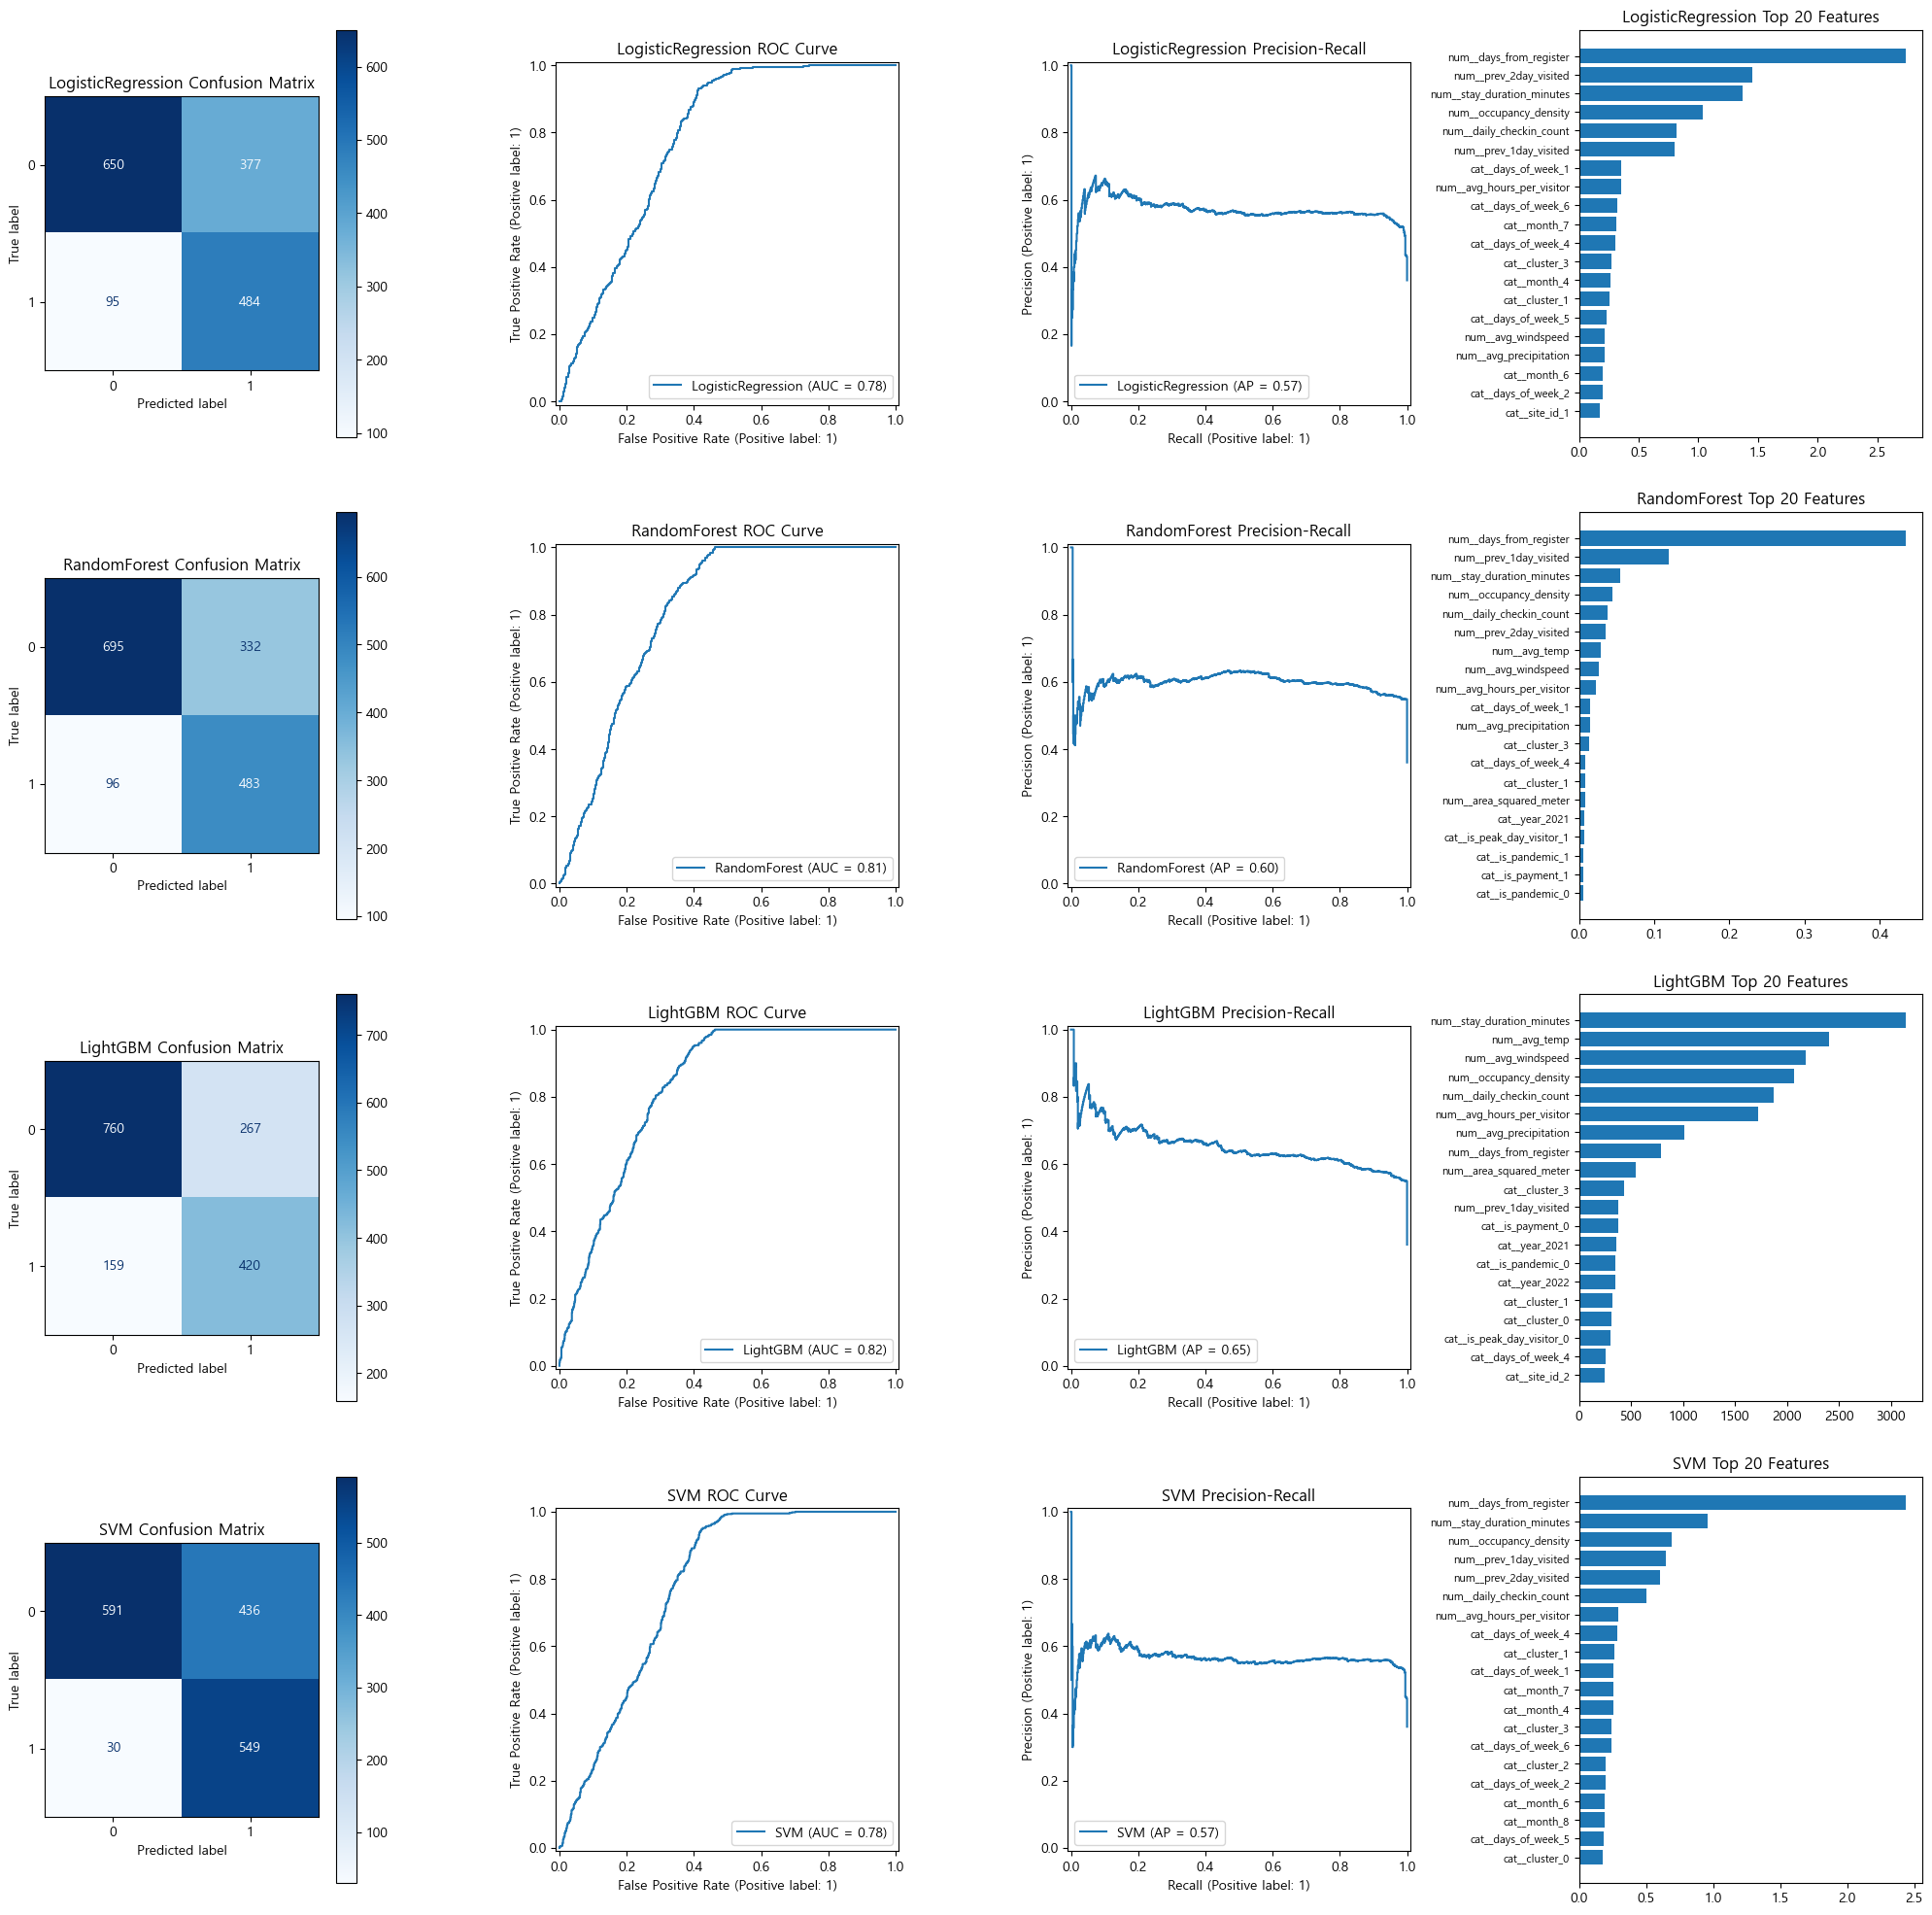

In [567]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# 1) 이미 최적 파라미터 세팅된 파이프라인 준비
best_pipelines = {}
for name, cfg in models.items():
    # 1-1) pipeline 재생성
    pipe = ImbPipeline([
        ('prep', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', cfg['est'])
    ])
    # 1-2) 파라미터 적용 (없으면 스킵)
    best_params = cfg.get('best_params_dict', {})
    if best_params:
        pipe.set_params(**{f"clf__{k}": v for k, v in best_params.items()})
    # 1-3) 재학습
    pipe.fit(X_train, y_train)
    best_pipelines[name] = pipe

# 2) 플롯용 축 생성 (모델 수 × 4개 차트)
n_models = len(best_pipelines)
fig, axes = plt.subplots(n_models, 4, figsize=(20, 5*n_models))

for i, (name, pipe) in enumerate(best_pipelines.items()):
    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    # 2-1) Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm,
                                     display_labels=pipe.named_steps['clf'].classes_)
    disp_cm.plot(ax=axes[i, 0], cmap='Blues', values_format='d')
    axes[i, 0].set_title(f'{name} Confusion Matrix')

    # 2-2) ROC Curve
    RocCurveDisplay.from_predictions(
        y_test, y_proba, ax=axes[i, 1], name=name
    )
    axes[i, 1].set_title(f'{name} ROC Curve')

    # 2-3) Precision-Recall Curve
    pr_disp = PrecisionRecallDisplay.from_predictions(
        y_test, y_proba, ax=axes[i, 2], name=name
    )
    axes[i, 2].set_title(f'{name} Precision-Recall')

    # 2-4) Feature Importance
    model = pipe.named_steps['clf']
    feat_names = pipe.named_steps['prep'].get_feature_names_out()
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        axes[i, 3].text(
            0.5, 0.5, 'No importance\nattribute',
            ha='center', va='center', fontsize=12
        )
        axes[i, 3].set_title(f'{name} Feature Importances')
        axes[i, 3].axis('off')
        continue

    # Top 20
    idx = np.argsort(importances)[::-1][:20]
    axes[i, 3].barh(feat_names[idx][::-1], importances[idx][::-1])
    axes[i, 3].set_title(f'{name} Top 20 Features')
    axes[i, 3].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()


### 8.3 추가 기법 적용

8.3.1 스태킹

In [575]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

# 베이스 모델로 이미 튜닝된 estimator들 가져오기
rf_best  = RandomForestClassifier(**models['RandomForest']['est'].get_params())
lgbm_best= LGBMClassifier(**models['LightGBM']['est'].get_params())
lr_best  = LogisticRegression(**models['LogisticRegression']['est'].get_params())
svm_best = models['SVM']['est']  

# StackingClassifier 정의
stack_est = StackingClassifier(
    estimators=[('rf', rf_best),
                ('lgbm', lgbm_best),
                ('lr', lr_best),
                ('svm', svm_best)],
    final_estimator=LogisticRegression(random_state=42),
    cv=5,
    n_jobs=-1,
    stack_method='predict_proba'
)

models['Stacking'] = {
    'est': stack_est,
    'space': {
        # 내부 이름은 'stack_C' 식으로 써도 되지만,
        # keys(외부 이름)는 final_estimator__C 로 맞춰야 합니다.
        'final_estimator__C'      : lambda t: t.suggest_loguniform('final_estimator__C',      1e-4, 1e2),
        'final_estimator__penalty': lambda t: t.suggest_categorical('final_estimator__penalty',['l2', None]),
        'final_estimator__solver' : lambda t: t.suggest_categorical('final_estimator__solver', ['lbfgs','saga']),
    },
    'trials': 30
}
for name, cfg in models.items():
    optimize_and_evaluate(
        name,
        cfg['est'],
        cfg.get('space', None),
        cfg.get('trials', 30)
    )

[I 2025-06-16 17:40:41,198] A new study created in memory with name: no-name-50b0f8e5-426c-41dc-b31e-d7a45486e074
C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\3316228033.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-06-16 17:40:41,306] Trial 0 finished with value: 0.8016662377476361 and parameters: {'C': 0.017670169402947963, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 480, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8016662377476361.
[I 2025-06-16 17:40:41,396] Trial 1 finished with value: 0.8028547498818022 and parameters: {'C': 0.4042872735027334, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 582, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8028547498818022.


[LogisticRegression] Baseline CV ROC-AUC : 0.8057


[I 2025-06-16 17:40:41,497] Trial 2 finished with value: 0.7964486964088252 and parameters: {'C': 0.006690421166498805, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 451, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8028547498818022.
[I 2025-06-16 17:40:42,779] Trial 3 finished with value: 0.805649316816974 and parameters: {'C': 0.054502936945582565, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 283, 'class_weight': None}. Best is trial 3 with value: 0.805649316816974.
[I 2025-06-16 17:40:42,871] Trial 4 finished with value: 0.7973165788231772 and parameters: {'C': 0.0002456459215250753, 'penalty': None, 'solver': 'lbfgs', 'max_iter': 375, 'class_weight': None}. Best is trial 3 with value: 0.805649316816974.
[I 2025-06-16 17:40:42,944] Trial 5 finished with value: 0.7829311744428056 and parameters: {'C': 0.0005397956855996448, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1393, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.805649316816974.
[I 2025-06-16 1

[LogisticRegression] Best CV ROC-AUC : 0.8057
[LogisticRegression] Best params       : {'C': 0.0654753165227121, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 1176, 'class_weight': None}
Test ROC-AUC : 0.7776544524101421
              precision    recall  f1-score   support

           0     0.8725    0.6329    0.7336      1027
           1     0.5621    0.8359    0.6722       579

    accuracy                         0.7061      1606
   macro avg     0.7173    0.7344    0.7029      1606
weighted avg     0.7606    0.7061    0.7115      1606

Top 20 features (|coef_|):
  num__days_from_register        2.7372
  num__prev_2day_visited         1.4548
  num__stay_duration_minutes     1.3710
  num__occupancy_density         1.0405
  num__daily_checkin_count       0.8139
  num__prev_1day_visited         0.7977
  cat__days_of_week_1            0.3549
  num__avg_hours_per_visitor     0.3529
  cat__days_of_week_6            0.3221
  cat__month_7                   0.3133
  cat__days_of_week_4   

[I 2025-06-16 17:40:57,893] A new study created in memory with name: no-name-87b9b79b-131d-44a2-8236-74b59b08ad9a


[RandomForest] Baseline CV ROC-AUC : 0.8418


C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\3316228033.py:23: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2025-06-16 17:40:58,932] Trial 0 finished with value: 0.840594060563217 and parameters: {'n_estimators': 437, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.9330880728874675, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.840594060563217.
[I 2025-06-16 17:41:05,819] Trial 1 finished with value: 0.8380601574942442 and parameters: {'n_estimators': 973, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'max_samples': 0.7159725093210578, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.840594060563217.
[I 2025-06-16 17:41:07,591] Trial 2 finished with value: 0.8367785582215603 and pa

[RandomForest] Best CV ROC-AUC : 0.8418
[RandomForest] Best params       : {'n_estimators': 740, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.8671955332946603, 'class_weight': 'balanced'}
Test ROC-AUC : 0.8077402364147298
              precision    recall  f1-score   support

           0     0.8786    0.6767    0.7646      1027
           1     0.5926    0.8342    0.6930       579

    accuracy                         0.7335      1606
   macro avg     0.7356    0.7555    0.7288      1606
weighted avg     0.7755    0.7335    0.7388      1606

Top 20 features (feature_importances_):
  num__days_from_register        0.4342
  num__prev_1day_visited         0.1199
  num__stay_duration_minutes     0.0542
  num__occupancy_density         0.0444
  num__daily_checkin_count       0.0377
  num__prev_2day_visited         0.0354
  num__avg_temp                  0.0284
  num__avg_windspeed             0.0264
  num__avg_

[I 2025-06-16 17:42:05,461] A new study created in memory with name: no-name-7f1ee342-53d6-41bc-bd3a-deb30a5bb73e


[LightGBM] Baseline CV ROC-AUC : 0.8385


C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\3316228033.py:32: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\3316228033.py:35: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\3316228033.py:36: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\3316228033.py:37: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases

[LightGBM] Best CV ROC-AUC : 0.8385
[LightGBM] Best params       : {'n_estimators': 519, 'learning_rate': 0.010074549321985413, 'num_leaves': 138, 'max_depth': 9, 'subsample': 0.7159288929998385, 'colsample_bytree': 0.5268327016249102, 'reg_alpha': 0.007806180353410627, 'reg_lambda': 2.4835146206149203e-07, 'min_split_gain': 4.637809966430951e-06, 'min_child_samples': 61}


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



Test ROC-AUC : 0.824823042111689
              precision    recall  f1-score   support

           0     0.8270    0.7400    0.7811      1027
           1     0.6114    0.7254    0.6635       579

    accuracy                         0.7347      1606
   macro avg     0.7192    0.7327    0.7223      1606
weighted avg     0.7492    0.7347    0.7387      1606

Top 20 features (feature_importances_):
  num__stay_duration_minutes     3143.0000
  num__avg_temp                  2408.0000
  num__avg_windspeed             2182.0000
  num__occupancy_density         2066.0000
  num__daily_checkin_count       1874.0000
  num__avg_hours_per_visitor     1728.0000
  num__avg_precipitation         1011.0000
  num__days_from_register        789.0000
  num__area_squared_meter        544.0000
  cat__cluster_3                 438.0000
  num__prev_1day_visited         379.0000
  cat__is_payment_0              378.0000
  cat__year_2021                 359.0000
  cat__is_pandemic_0             351.0000
  cat

[I 2025-06-16 17:45:38,593] A new study created in memory with name: no-name-541d8a09-6d51-41c4-878a-c8ac2e72316c


[SVM] Baseline CV ROC-AUC : 0.8066


C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\3316228033.py:47: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\3316228033.py:51: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2025-06-16 17:45:42,462] Trial 0 finished with value: 0.8035637651546661 and parameters: {'C': 0.1767016940294795, 'kernel': 'linear', 'gamma': 'scale', 'degree': 2, 'coef0': 0.8661761457749352}. Best is trial 0 with value: 0.8035637651546661.
[I 2025-06-16 17:45:46,916] Trial 1 finished with value: 0.7815439030485462 and parameters: {'C': 4.0428727350273315, 'kernel': 'poly', 'gamma': 'scale', 'degree': 2, 'coef0': 0.18340450985343382}. Best is trial 0 with value:

[SVM] Best CV ROC-AUC : 0.8066
[SVM] Best params       : {'C': 0.027567634290324907, 'kernel': 'linear', 'gamma': 'scale', 'degree': 2, 'coef0': 0.7100165208229793}
Test ROC-AUC : 0.7765041630720124
              precision    recall  f1-score   support

           0     0.9517    0.5755    0.7172      1027
           1     0.5574    0.9482    0.7020       579

    accuracy                         0.7098      1606
   macro avg     0.7545    0.7618    0.7096      1606
weighted avg     0.8095    0.7098    0.7118      1606

Top 20 features (|coef_|):
  num__days_from_register        2.4369
  num__stay_duration_minutes     0.9594
  num__occupancy_density         0.6892
  num__prev_1day_visited         0.6447
  num__prev_2day_visited         0.6019
  num__daily_checkin_count       0.5012
  num__avg_hours_per_visitor     0.2904
  cat__days_of_week_4            0.2832
  cat__cluster_1                 0.2654
  cat__days_of_week_1            0.2599
  cat__month_7                   0.2568
  cat__

[I 2025-06-16 17:48:46,649] A new study created in memory with name: no-name-4ba288bf-63c2-4c58-a6d2-175fa1017fd4


[Stacking] Baseline CV ROC-AUC : 0.7467


C:\Users\Yoo\AppData\Local\Temp\ipykernel_40112\101729052.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-06-16 17:49:33,407] Trial 0 finished with value: 0.8300924129924689 and parameters: {'final_estimator__C': 0.017670169402947963, 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'lbfgs'}. Best is trial 0 with value: 0.8300924129924689.
[I 2025-06-16 17:50:17,065] Trial 1 finished with value: 0.7184735682732744 and parameters: {'final_estimator__C': 0.0008629132190071859, 'final_estimator__penalty': None, 'final_estimator__solver': 'saga'}. Best is trial 0 with value: 0.8300924129924689.
[I 2025-06-16 17:51:04,378] Trial 2 finished with value: 0.839238426975815 and parameters: {'final_estimator__C': 0.00013289448722869195, 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'lbfgs'}. Best is

[Stacking] Best CV ROC-AUC : 0.8404
[Stacking] Best params       : {'final_estimator__C': 0.0022540213474182003, 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'lbfgs'}


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



Test ROC-AUC : 0.8209635186745438
              precision    recall  f1-score   support

           0     0.7878    0.7770    0.7824      1027
           1     0.6138    0.6287    0.6212       579

    accuracy                         0.7235      1606
   macro avg     0.7008    0.7028    0.7018      1606
weighted avg     0.7251    0.7235    0.7242      1606

  (feature_importances_ 또는 coef_ 속성이 없음)
------------------------------------------------------------


8.3.2 AutoML

In [571]:
from flaml import AutoML
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, classification_report

# 1) 학습 데이터 SMOTE까지 적용
pipe_prep_smote = ImbPipeline([
    ('prep',   preprocessor),
    ('smote',  SMOTE(random_state=42)),
])
X_train_prepped, y_train_prepped = pipe_prep_smote.fit_resample(X_train, y_train)

# 2) 테스트 데이터는 전처리만
X_test_prepped = preprocessor.transform(X_test)

# 3) FLAML 설정
automl = AutoML()
automl_settings = {
    "time_budget":    600,
    "metric":         "roc_auc",
    "task":           "classification",
    "log_file_name":  "flaml.log",
    "seed":           42,
}

# 4) 학습
automl.fit(X_train=X_train_prepped, y_train=y_train_prepped, **automl_settings)

# 5) 평가
y_proba = automl.predict_proba(X_test_prepped)[:,1]
y_pred  = automl.predict(X_test_prepped)
print("FLAML Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=4))

[flaml.automl.logger: 06-16 16:03:17] {1728} INFO - task = classification
[flaml.automl.logger: 06-16 16:03:17] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 06-16 16:03:17] {1838} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 06-16 16:03:17] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost', 'lrl1']
[flaml.automl.logger: 06-16 16:03:17] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-16 16:03:17] {2393} INFO - Estimated sufficient time budget=865s. Estimated necessary time budget=21s.
[flaml.automl.logger: 06-16 16:03:17] {2442} INFO -  at 0.1s,	estimator lgbm's best error=0.1547,	best estimator lgbm's best error=0.1547
[flaml.automl.logger: 06-16 16:03:17] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-16 16:03:17] {2442} INFO -  at 0.2s,	estimator lgbm's best error=0.1547,	best estimator lgbm's best error=0.1547
[flaml.automl.log

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\s

[flaml.automl.logger: 06-16 16:03:17] {2442} INFO -  at 0.3s,	estimator lgbm's best error=0.1323,	best estimator lgbm's best error=0.1323
[flaml.automl.logger: 06-16 16:03:17] {2258} INFO - iteration 3, current learner sgd


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:18] {2442} INFO -  at 0.7s,	estimator sgd's best error=0.2339,	best estimator lgbm's best error=0.1323
[flaml.automl.logger: 06-16 16:03:18] {2258} INFO - iteration 4, current learner xgboost
[flaml.automl.logger: 06-16 16:03:18] {2442} INFO -  at 0.8s,	estimator xgboost's best error=0.1588,	best estimator lgbm's best error=0.1323
[flaml.automl.logger: 06-16 16:03:18] {2258} INFO - iteration 5, current learner lgbm
[flaml.automl.logger: 06-16 16:03:18] {2442} INFO -  at 0.9s,	estimator lgbm's best error=0.1221,	best estimator lgbm's best error=0.1221
[flaml.automl.logger: 06-16 16:03:18] {2258} INFO - iteration 6, current learner lgbm
[flaml.automl.logger: 06-16 16:03:18] {2442} INFO -  at 1.0s,	estimator lgbm's best error=0.1221,	best estimator lgbm's best error=0.1221
[flaml.automl.logger: 06-16 16:03:18] {2258} INFO - iteration 7, current learner lgbm


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\s

[flaml.automl.logger: 06-16 16:03:18] {2442} INFO -  at 1.1s,	estimator lgbm's best error=0.1210,	best estimator lgbm's best error=0.1210
[flaml.automl.logger: 06-16 16:03:18] {2258} INFO - iteration 8, current learner lgbm
[flaml.automl.logger: 06-16 16:03:18] {2442} INFO -  at 1.2s,	estimator lgbm's best error=0.1210,	best estimator lgbm's best error=0.1210


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\s

[flaml.automl.logger: 06-16 16:03:18] {2258} INFO - iteration 9, current learner lgbm
[flaml.automl.logger: 06-16 16:03:19] {2442} INFO -  at 1.4s,	estimator lgbm's best error=0.0845,	best estimator lgbm's best error=0.0845
[flaml.automl.logger: 06-16 16:03:19] {2258} INFO - iteration 10, current learner xgboost


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:19] {2442} INFO -  at 1.5s,	estimator xgboost's best error=0.1588,	best estimator lgbm's best error=0.0845
[flaml.automl.logger: 06-16 16:03:19] {2258} INFO - iteration 11, current learner xgboost
[flaml.automl.logger: 06-16 16:03:19] {2442} INFO -  at 1.6s,	estimator xgboost's best error=0.1412,	best estimator lgbm's best error=0.0845
[flaml.automl.logger: 06-16 16:03:19] {2258} INFO - iteration 12, current learner extra_tree
[flaml.automl.logger: 06-16 16:03:19] {2442} INFO -  at 1.8s,	estimator extra_tree's best error=0.1924,	best estimator lgbm's best error=0.0845
[flaml.automl.logger: 06-16 16:03:19] {2258} INFO - iteration 13, current learner rf
[flaml.automl.logger: 06-16 16:03:19] {2442} INFO -  at 2.0s,	estimator rf's best error=0.1594,	best estimator lgbm's best error=0.0845
[flaml.automl.logger: 06-16 16:03:19] {2258} INFO - iteration 14, current learner rf
[flaml.automl.logger: 06-16 16:03:19] {2442} INFO -  at 2.3s,	estimator rf's best err

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:20] {2442} INFO -  at 2.9s,	estimator sgd's best error=0.2339,	best estimator lgbm's best error=0.0845
[flaml.automl.logger: 06-16 16:03:20] {2258} INFO - iteration 19, current learner lgbm
[flaml.automl.logger: 06-16 16:03:20] {2442} INFO -  at 3.1s,	estimator lgbm's best error=0.0742,	best estimator lgbm's best error=0.0742
[flaml.automl.logger: 06-16 16:03:20] {2258} INFO - iteration 20, current learner xgboost


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:20] {2442} INFO -  at 3.2s,	estimator xgboost's best error=0.1412,	best estimator lgbm's best error=0.0742
[flaml.automl.logger: 06-16 16:03:20] {2258} INFO - iteration 21, current learner lgbm
[flaml.automl.logger: 06-16 16:03:21] {2442} INFO -  at 3.4s,	estimator lgbm's best error=0.0742,	best estimator lgbm's best error=0.0742
[flaml.automl.logger: 06-16 16:03:21] {2258} INFO - iteration 22, current learner rf


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:21] {2442} INFO -  at 3.7s,	estimator rf's best error=0.1594,	best estimator lgbm's best error=0.0742
[flaml.automl.logger: 06-16 16:03:21] {2258} INFO - iteration 23, current learner lgbm


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:21] {2442} INFO -  at 4.4s,	estimator lgbm's best error=0.0501,	best estimator lgbm's best error=0.0501
[flaml.automl.logger: 06-16 16:03:21] {2258} INFO - iteration 24, current learner lgbm


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:22] {2442} INFO -  at 4.6s,	estimator lgbm's best error=0.0501,	best estimator lgbm's best error=0.0501
[flaml.automl.logger: 06-16 16:03:22] {2258} INFO - iteration 25, current learner sgd


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:22] {2442} INFO -  at 5.1s,	estimator sgd's best error=0.1910,	best estimator lgbm's best error=0.0501
[flaml.automl.logger: 06-16 16:03:22] {2258} INFO - iteration 26, current learner sgd
[flaml.automl.logger: 06-16 16:03:23] {2442} INFO -  at 5.7s,	estimator sgd's best error=0.1910,	best estimator lgbm's best error=0.0501
[flaml.automl.logger: 06-16 16:03:23] {2258} INFO - iteration 27, current learner lgbm


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:23] {2442} INFO -  at 6.2s,	estimator lgbm's best error=0.0501,	best estimator lgbm's best error=0.0501
[flaml.automl.logger: 06-16 16:03:23] {2258} INFO - iteration 28, current learner rf


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:24] {2442} INFO -  at 6.4s,	estimator rf's best error=0.1594,	best estimator lgbm's best error=0.0501
[flaml.automl.logger: 06-16 16:03:24] {2258} INFO - iteration 29, current learner xgboost
[flaml.automl.logger: 06-16 16:03:24] {2442} INFO -  at 6.5s,	estimator xgboost's best error=0.1140,	best estimator lgbm's best error=0.0501
[flaml.automl.logger: 06-16 16:03:24] {2258} INFO - iteration 30, current learner xgboost
[flaml.automl.logger: 06-16 16:03:24] {2442} INFO -  at 6.6s,	estimator xgboost's best error=0.1140,	best estimator lgbm's best error=0.0501
[flaml.automl.logger: 06-16 16:03:24] {2258} INFO - iteration 31, current learner lgbm


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:25] {2442} INFO -  at 7.4s,	estimator lgbm's best error=0.0501,	best estimator lgbm's best error=0.0501
[flaml.automl.logger: 06-16 16:03:25] {2258} INFO - iteration 32, current learner lgbm


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:30] {2442} INFO -  at 12.6s,	estimator lgbm's best error=0.0379,	best estimator lgbm's best error=0.0379
[flaml.automl.logger: 06-16 16:03:30] {2258} INFO - iteration 33, current learner catboost


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:35] {2442} INFO -  at 18.2s,	estimator catboost's best error=0.0471,	best estimator lgbm's best error=0.0379
[flaml.automl.logger: 06-16 16:03:35] {2258} INFO - iteration 34, current learner rf
[flaml.automl.logger: 06-16 16:03:36] {2442} INFO -  at 18.4s,	estimator rf's best error=0.1594,	best estimator lgbm's best error=0.0379
[flaml.automl.logger: 06-16 16:03:36] {2258} INFO - iteration 35, current learner sgd
[flaml.automl.logger: 06-16 16:03:36] {2442} INFO -  at 18.8s,	estimator sgd's best error=0.1839,	best estimator lgbm's best error=0.0379
[flaml.automl.logger: 06-16 16:03:36] {2258} INFO - iteration 36, current learner rf
[flaml.automl.logger: 06-16 16:03:36] {2442} INFO -  at 19.0s,	estimator rf's best error=0.1594,	best estimator lgbm's best error=0.0379
[flaml.automl.logger: 06-16 16:03:36] {2258} INFO - iteration 37, current learner xgboost
[flaml.automl.logger: 06-16 16:03:36] {2442} INFO -  at 19.2s,	estimator xgboost's best error=0.087

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:47] {2442} INFO -  at 29.4s,	estimator lgbm's best error=0.0379,	best estimator lgbm's best error=0.0379
[flaml.automl.logger: 06-16 16:03:47] {2258} INFO - iteration 46, current learner xgb_limitdepth
[flaml.automl.logger: 06-16 16:03:47] {2442} INFO -  at 29.5s,	estimator xgb_limitdepth's best error=0.0890,	best estimator lgbm's best error=0.0379


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:47] {2258} INFO - iteration 47, current learner catboost
[flaml.automl.logger: 06-16 16:03:57] {2442} INFO -  at 40.3s,	estimator catboost's best error=0.0451,	best estimator lgbm's best error=0.0379
[flaml.automl.logger: 06-16 16:03:57] {2258} INFO - iteration 48, current learner xgb_limitdepth
[flaml.automl.logger: 06-16 16:03:58] {2442} INFO -  at 40.4s,	estimator xgb_limitdepth's best error=0.0790,	best estimator lgbm's best error=0.0379
[flaml.automl.logger: 06-16 16:03:58] {2258} INFO - iteration 49, current learner xgboost
[flaml.automl.logger: 06-16 16:03:58] {2442} INFO -  at 40.6s,	estimator xgboost's best error=0.0838,	best estimator lgbm's best error=0.0379
[flaml.automl.logger: 06-16 16:03:58] {2258} INFO - iteration 50, current learner xgb_limitdepth
[flaml.automl.logger: 06-16 16:03:58] {2442} INFO -  at 40.7s,	estimator xgb_limitdepth's best error=0.0790,	best estimator lgbm's best error=0.0379
[flaml.automl.logger: 06-16 16:03:58] {225

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:59] {2442} INFO -  at 41.5s,	estimator lgbm's best error=0.0379,	best estimator lgbm's best error=0.0379
[flaml.automl.logger: 06-16 16:03:59] {2258} INFO - iteration 52, current learner xgb_limitdepth


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:03:59] {2442} INFO -  at 41.8s,	estimator xgb_limitdepth's best error=0.0669,	best estimator lgbm's best error=0.0379
[flaml.automl.logger: 06-16 16:03:59] {2258} INFO - iteration 53, current learner xgb_limitdepth
[flaml.automl.logger: 06-16 16:03:59] {2442} INFO -  at 42.2s,	estimator xgb_limitdepth's best error=0.0572,	best estimator lgbm's best error=0.0379
[flaml.automl.logger: 06-16 16:03:59] {2258} INFO - iteration 54, current learner extra_tree
[flaml.automl.logger: 06-16 16:04:00] {2442} INFO -  at 42.4s,	estimator extra_tree's best error=0.1895,	best estimator lgbm's best error=0.0379
[flaml.automl.logger: 06-16 16:04:00] {2258} INFO - iteration 55, current learner xgb_limitdepth
[flaml.automl.logger: 06-16 16:04:00] {2442} INFO -  at 42.7s,	estimator xgb_limitdepth's best error=0.0572,	best estimator lgbm's best error=0.0379
[flaml.automl.logger: 06-16 16:04:00] {2258} INFO - iteration 56, current learner lgbm


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:04:15] {2442} INFO -  at 58.2s,	estimator lgbm's best error=0.0366,	best estimator lgbm's best error=0.0366
[flaml.automl.logger: 06-16 16:04:15] {2258} INFO - iteration 57, current learner lgbm


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:04:41] {2442} INFO -  at 83.7s,	estimator lgbm's best error=0.0358,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:04:41] {2258} INFO - iteration 58, current learner xgb_limitdepth


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:04:41] {2442} INFO -  at 83.9s,	estimator xgb_limitdepth's best error=0.0572,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:04:41] {2258} INFO - iteration 59, current learner xgboost
[flaml.automl.logger: 06-16 16:04:42] {2442} INFO -  at 84.4s,	estimator xgboost's best error=0.0782,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:04:42] {2258} INFO - iteration 60, current learner xgboost
[flaml.automl.logger: 06-16 16:04:42] {2442} INFO -  at 84.8s,	estimator xgboost's best error=0.0782,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:04:42] {2258} INFO - iteration 61, current learner xgb_limitdepth
[flaml.automl.logger: 06-16 16:04:43] {2442} INFO -  at 85.7s,	estimator xgb_limitdepth's best error=0.0548,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:04:43] {2258} INFO - iteration 62, current learner lrl1
[flaml.automl.logger: 06-16 16:04:43] {2442} INFO -  a

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:05:01] {2442} INFO -  at 103.8s,	estimator lgbm's best error=0.0358,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:05:01] {2258} INFO - iteration 66, current learner extra_tree


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:05:01] {2442} INFO -  at 104.0s,	estimator extra_tree's best error=0.1820,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:05:01] {2258} INFO - iteration 67, current learner xgb_limitdepth
[flaml.automl.logger: 06-16 16:05:02] {2442} INFO -  at 104.5s,	estimator xgb_limitdepth's best error=0.0548,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:05:02] {2258} INFO - iteration 68, current learner lgbm


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:05:10] {2442} INFO -  at 112.4s,	estimator lgbm's best error=0.0358,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:05:10] {2258} INFO - iteration 69, current learner xgboost


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:05:11] {2442} INFO -  at 114.1s,	estimator xgboost's best error=0.0624,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:05:11] {2258} INFO - iteration 70, current learner extra_tree
[flaml.automl.logger: 06-16 16:05:11] {2442} INFO -  at 114.3s,	estimator extra_tree's best error=0.1820,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:05:11] {2258} INFO - iteration 71, current learner xgboost
[flaml.automl.logger: 06-16 16:05:13] {2442} INFO -  at 116.1s,	estimator xgboost's best error=0.0624,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:05:13] {2258} INFO - iteration 72, current learner lgbm


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:06:22] {2442} INFO -  at 185.0s,	estimator lgbm's best error=0.0358,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:06:22] {2258} INFO - iteration 73, current learner extra_tree


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:06:23] {2442} INFO -  at 185.4s,	estimator extra_tree's best error=0.1820,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:06:23] {2258} INFO - iteration 74, current learner xgb_limitdepth
[flaml.automl.logger: 06-16 16:06:24] {2442} INFO -  at 187.1s,	estimator xgb_limitdepth's best error=0.0446,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:06:24] {2258} INFO - iteration 75, current learner xgb_limitdepth
[flaml.automl.logger: 06-16 16:06:25] {2442} INFO -  at 187.5s,	estimator xgb_limitdepth's best error=0.0446,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:06:25] {2258} INFO - iteration 76, current learner sgd
[flaml.automl.logger: 06-16 16:06:27] {2442} INFO -  at 189.4s,	estimator sgd's best error=0.1839,	best estimator lgbm's best error=0.0358
[flaml.automl.logger: 06-16 16:06:27] {2258} INFO - iteration 77, current learner xgb_limitdepth
[flaml.automl.logger: 06-16 16:06:33] 

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:09:32] {2442} INFO -  at 374.8s,	estimator lgbm's best error=0.0358,	best estimator xgboost's best error=0.0297
[flaml.automl.logger: 06-16 16:09:32] {2258} INFO - iteration 107, current learner extra_tree


c:\Users\Yoo\.conda\envs\codeit_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



[flaml.automl.logger: 06-16 16:09:32] {2442} INFO -  at 375.0s,	estimator extra_tree's best error=0.1624,	best estimator xgboost's best error=0.0297
[flaml.automl.logger: 06-16 16:09:32] {2258} INFO - iteration 108, current learner xgboost
[flaml.automl.logger: 06-16 16:09:45] {2442} INFO -  at 387.5s,	estimator xgboost's best error=0.0278,	best estimator xgboost's best error=0.0278
[flaml.automl.logger: 06-16 16:09:45] {2258} INFO - iteration 109, current learner extra_tree
[flaml.automl.logger: 06-16 16:09:45] {2442} INFO -  at 387.7s,	estimator extra_tree's best error=0.1600,	best estimator xgboost's best error=0.0278
[flaml.automl.logger: 06-16 16:09:45] {2258} INFO - iteration 110, current learner sgd
[flaml.automl.logger: 06-16 16:09:45] {2442} INFO -  at 388.0s,	estimator sgd's best error=0.1385,	best estimator xgboost's best error=0.0278
[flaml.automl.logger: 06-16 16:09:45] {2258} INFO - iteration 111, current learner xgboost
[flaml.automl.logger: 06-16 16:10:03] {2442} INFO -

# 9. 결론 및 액션 아이템 제시

### 9.1 모델간 성능 지표 비교

| 모델                       | Test ROC-AUC | Accuracy | Positive(1) Precision | Positive Recall | Positive F1 | Negative(0) Precision | Negative Recall | Negative F1 |
| ------------------------ | -----------: | -------: | --------------------: | --------------: | ----------: | --------------------: | --------------: | ----------: |
|  로지스틱 회귀            |       0.7777 |   0.7061 |                0.5621 |          0.8359 |      0.6722 |                0.8725 |          0.6329 |      0.7336 |
| 랜덤 포레스트            |       0.8077 |   0.7335 |                0.5926 |          0.8342 |      0.6930 |                0.8786 |          0.6767 |      0.7646 |
|  LightGBM           |       0.8248 |   0.7347 |                0.6114 |          0.7254 |      0.6635 |                0.8270 |          0.7400 |      0.7811 |
|  서포트 벡터 머신                |       0.7765 |   0.7098 |                0.5574 |          0.9482 |      0.7020 |                0.9517 |          0.5755 |      0.7172 |
|  Stacking 앙상블       |       0.8210 |   0.7235 |                0.6138 |          0.6287 |      0.6212 |                0.7878 |          0.7770 |      0.7824 |
| FLAML (ExtraTrees) |       0.8019 |   0.6843 |                0.6047 |          0.3592 |      0.4507 |                0.7060 |          0.8676 |      0.7785 |


- 최고 ROC-AUC: LightGBM (0.8248)

- 최고 Positive 클래스 F1: RandomForest (0.6930)

- 최고 Recall(Positive): SVM (0.9482)

- 최고 Precision(Positive): LightGBM (0.6114)

- 최고 Negative Recall: FLAML (0.8676)



9.1.1 로지스틱 회귀
- CV ROC–AUC : 0.8057

- 최적 하이퍼파라미터
```
n_estimators:    740  
max_depth:       12  
min_samples_split: 15  
min_samples_leaf: 9  
max_features:    sqrt  
bootstrap:       True  
max_samples:     0.867  
class_weight:    balanced
```

- 테스트 ROC–AUC: 0.7777

- 상위 계수

1. num__days_from_register ( +2.737)

2. num__prev_2day_visited (+1.455)

3. num__stay_duration_minutes (+1.371)

4. num__occupancy_density (+1.040)

5. num__daily_checkin_count (+0.814)

6. num__prev_1day_visited (+0.798)

7. cat__days_of_week_1 (+0.355)

8. num__avg_hours_per_visitor (+0.353)

9.1.2 랜덤 포레스트

- CV ROC–AUC : 0.8418

- 최적 하이퍼파라미터
```
n_estimators:    740  
max_depth:       12  
min_samples_split: 15  
min_samples_leaf: 9  
max_features:    sqrt  
bootstrap:       True  
max_samples:     0.867  
class_weight:    balanced
```

- 테스트 ROC–AUC: 0.8077

- 피처 중요도

1. num__days_from_register ( 0.4342)

2. num__prev_1day_visited (0.1199)

3. num__stay_duration_minutes (0.0542)

4. num__occupancy_density (0.0444)

5. num__daily_checkin_count (0.0377)

6. num__prev_2day_visited (0.0354)

7. num__avg_temp (0.0284)

9.1.3 LightGBM

- CV ROC–AUC: 0.8385

- 최적 하이퍼파라미터

```
n_estimators:      519  
learning_rate:     0.01007  
num_leaves:        138  
max_depth:         9  
subsample:         0.7159  
colsample_bytree:  0.5268  
reg_alpha:         7.8e-03  
reg_lambda:        2.5e-07  
min_split_gain:    4.6e-06  
min_child_samples: 61
```

- 테스트 ROC–AUC: 0.8248

- 피처 중요도

1. num__stay_duration_minutes (3143)

2. num__avg_temp (2408)

3. num__avg_windspeed (2182)

4. num__occupancy_density (2066)

5. num__daily_checkin_count (1874)

6. num__avg_hours_per_visitor (1728)

7. num__avg_precipitation (1011)

9.1.4 서포트 벡터 머신

- CV ROC–AUC: 0.8066

- 최적 하이퍼파라미터

```
C:      0.02757  
kernel: linear  
gamma:  scale  
degree: 2  
coef0:  0.7100
```
- 테스트 ROC-AUC: 0.7765

- 상위 계수

1. num__days_from_register (+2.437)

2. num__stay_duration_minutes (+0.959)

3. num__occupancy_density (+0.689)

4. num__prev_1day_visited (+0.645)

9.1.5 스태킹 앙상블 모형 (번외)

- CV ROC–AUC: 0.8404

- 최적 하이퍼파라미터 (최종 메타 모델 = LogisticRegression)

```
final_estimator__C:       0.00225  
final_estimator__penalty: l2  
final_estimator__solver:  lbfgs
```
- 테스트 ROC–AUC: 0.8210


9.1.6 AutoML (번외)

- 최적 하이퍼파라미터
```
criterion=np.str_('entropy'),
                     max_features=np.float64(0.11593436640709787),
                     max_leaf_nodes=4213, n_estimators=1002, n_jobs=-1,
                     random_state=12032022
```

- 테스트 ROC-AUC : 0.8019	 

### 9.2 결론 및 제언

- LightGBM
    - 전체 ROC-AUC가 가장 높아 전반적인 순위 결정 능력이 우수함.
    - 다만 Positive 클래스 리콜(0.7254)이 SVM, 랜덤 포레스트 대비 다소 낮아, 재방문자(Positive) 탐지율을 높이기 위해 Recall을 높이는 모델 검토 필요.

- 랜덤 포레스트
    - F1(Positive) 0.6930으로 불균형 데이터에서 양호한 균형을 보였음.
    - 안정적인 성능과 피처 중요도(예: days_from_register, prev_1day_visited)를 통해 해석 가능성이 용이했음.

- 서포트 벡터 머신
    - 이진분류에 강한 알고리즘인 만큼 Positive 리콜이 0.9482로 매우 높아 재방문자를 놓치는 비율이 낮았음.
    - 그러나 Precision(0.5574)이 낮아, 많은 오탐(False Positive)이 발생할 수 있으므로 모델 조정이 필요했음.

- 스태킹 앙상블
    - CV 상으로는 가장 높은 ROC-AUC(0.8404)를 기록했으나, Test 성능(0.8210)은 단일 LightGBM보다는 성능이 떨어졌음.
    - 스태킹 과정에서의 오버피팅 가능성을 염두에 두고, 메타 모델의 복잡도를 조정하고, 이 외의 하이퍼 파라미터 튜닝을 적용

- AutoML (ExtraTreesClassifier)
    - 자동화된 모델 탐색으로 ROC-AUC 0.8019, Negative 리콜 0.8676의 안정적 탐지율.
    - 하지만 Positive 리콜(0.3592)과 F1(0.4507)이 낮아, 재방문자 예측에는 한계가 존재했음.




- 총평

    - 여러 모델 중 LightGBM이 전반적인 분류 성능(ROC-AUC)에서 가장 뛰어났으며, 랜덤 포레스트는 Positive F1-score 측면에서 안정적인 균형을 보였습니다.

    - SVM은 재방문자 검출(Recall)을 극대화했으나 오탐률(Precision)이 높아, 실제 비즈니스 상황에 맞춘 임계값 조정이 필요합니다.

    - 스태킹 앙상블은 CV 단계에서 잠재력이 컸으나, Test 성능 저하로 과적합 우려가 있으며, 메타 모델 경량화 및 추가 튜닝으로 개선 가능성이 있습니다.

    - AutoML(ExtraTrees)은 빠르고 안정적인 탐색 결과를 제공했으나, 재방문자 예측력(Recall, F1)이 낮아 후처리(임계값 최적화) 및 샘플링 보완이 필수적입니다.

LightGBM을 기준 모델로 삼되, 임계값 및 클래스 가중치 조정, SHAP을 통해 어떤 피처가 영향을 끼치는지 확인하여 피처 조정을 한 뒤, 보팅 앙상블 또는 RF 결합을 통해 안정성과 예측력을 함께 끌어올리는 모델을 방향으로 잡는게 좋아보였음.